In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy, os

from skimage import io, exposure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.draw import disk as pdisk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_otsu, threshold_li, threshold_multiotsu, rank, threshold_sauvola
from skimage.filters import sobel

from scipy.stats import skew
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import csv

from scipy.stats import skew
from scipy.signal import argrelextrema
import concurrent.futures
from matplotlib.widgets import Slider
from pathlib import Path


/home/user/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
PRECISION = 50

In [3]:
class IegImgParams(): 
    def __init__(self, path, thre, skewness, bgr):
        self.path = path
        self.thre = thre
        self.skewness = skewness
        self.bgr = bgr
        self.dots = np.array([])

In [4]:
class Approximation(): 
    def __init__(self, reg_props, approx_patch, intensity,  idno):
        self.reg_props = reg_props
        self.approx_patch = approx_patch
        self.intensity = intensity
        self.idno = idno

In [5]:
def background_filter(flattened_img):
    hist, bins = np.histogram(flattened_img, int(pow(PRECISION, 2)/20))
    mode_idx = np.argmax(hist)
    mode = bins[mode_idx]
    return mode

In [6]:
def reflect(image_ts):
    height = image_ts.shape[0]
    image_ts = np.transpose(image_ts)
    to_ret = np.copy(image_ts)
    for col_no, column in enumerate(image_ts):
        nonzero = False
        idx = 0
        while not nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        start_idx = idx - 1
        while nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        stop_idx = idx - 1
        reflection = np.flip(column[start_idx:stop_idx])
        reflect_offset_up = start_idx - len(reflection)
        reflect_offset_down = stop_idx + len(reflection)
        to_ret[col_no][max(0, reflect_offset_up):start_idx] = reflection[max(0, -reflect_offset_up):]
        to_ret[col_no][stop_idx:min(reflect_offset_down, height)] = reflection[:min(len(reflection)+1, height - stop_idx)]
    return np.transpose(to_ret)

In [39]:
def calculate_ieg_segm_mask(image_ts):
    reflected = reflect(image_ts)
    
    background = ndi.generic_filter(reflected, background_filter, size=50)
    skewness = skew(image_ts[image_ts>0])
    mask = image_ts > (threshold_otsu(image_ts[image_ts>0])*5/skewness + background)
    
    return threshold_otsu(image_ts[image_ts>0]), background, skewness



def calculate_ieg_segm_params(image_ts):
    
    image_ts = ndi.gaussian_filter(image_ts, 3)
    reflected = reflect(image_ts)
    #background = ndi.generic_filter(reflected, background_filter, size=PRECISION)
    background = threshold_sauvola(reflected, 13, k=0.001)
    skewness = skew(image_ts[image_ts>0])
    
    return threshold_otsu(image_ts[image_ts>0]), background, skewness

In [40]:
def ieg_segmentation(image_ts, thresh_down, thresh_up, thresh_range, mask): 

        
    elev_map = sobel(image_ts)
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
                                labels=mask)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-elev_map, markers, mask=mask)
    label_image = label(labels, connectivity = 1)
    
    
    masked = np.ma.masked_array(data = image_ts, mask = mask, fill_value = 0).filled()

    intensities_normalized = np.array([])
    dots = np.array([])
    areas = np.array([])
    
    for region in regionprops(label_image, intensity_image=image_ts):
        reg_app_w_bgr = pdisk(region.centroid, 7, shape = image_ts.shape)
        reg_approx = pdisk(region.centroid, 5, shape = image_ts.shape)
        reg_intensity = 2*np.sum(image_ts[reg_approx]) - np.sum(image_ts[reg_app_w_bgr])
        circ = mpatches.Circle((region.centroid[1], region.centroid[0]), 5, 
                               fill=False, edgecolor="red", linewidth=2)
        new_dot = Approximation(region, copy.copy(circ), reg_intensity, len(dots))
        dots = np.append(dots, new_dot)
        intensities_normalized = np.append(intensities_normalized, reg_intensity)
        areas = np.append(areas, region.area)

    return dots, intensities_normalized, areas

In [41]:
scan_path_root = "/mnt/ula/catfish/test_scans/"

suffix = "/3.tif"
overlay_suffix = "/overlay3.tif"
csv_suffix = "/3.csv"

In [42]:
def process_scan(img_path):
    print(img_path)
    ieg_img = io.imread(img_path + suffix)
    thre, background, skewness = calculate_ieg_segm_params(ieg_img)
    res = IegImgParams(img_path, thre, skewness, background)
    return res

In [43]:
#MAIN loop to walk through img folder, looking for FOLDERS
to_process = np.array([])

for filename in os.listdir(scan_path_root):
    path = scan_path_root + filename
    if os.path.isdir(path):
        to_process = np.append(to_process, path)

results = np.array([])

with concurrent.futures.ProcessPoolExecutor(20) as executor: 
    for result in executor.map(process_scan, to_process):
        results = np.append(results, result)
plt.close()

/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_3_hipp_right_skan_2019-10-08_135307
/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_16_hipp_left_skan_2019-10-11_135612
/mnt/ula/catfish/test_scans/CA1_left_glass_1_rat_3_hipp_left_skan_2019-10-08_130731
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_19_hipp_right_skan_2019-10-14_114530
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_14_hipp_right_skan_2019-10-11_151922
/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_17_hipp_left_skan_2019-10-14_101906
/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_6_hipp_right_skan_2019-10-09_114941
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_2_hipp_right_skan_2019-10-08_113103
/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_7_hipp_right_skan_2019-10-09_094010
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_4_hipp_right_skan_2019-10-08_151512
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_16_hipp_right_skan_2019-10-11_143612
/mnt/ula/catfish/test_scans/CA1_left_glass_23_ra

In [106]:
def plot_intensities_normalized(result, k1, k2):
    plt.ioff()
    ieg_img = io.imread(result.path+suffix)
    
    blurred = ndi.gaussian_filter(img, 3)
    thre  = threshold_otsu(blurred[blurred>mode_filter(blurred)])
    
    mask = ieg_img > (thre*k1 + result.bgr*k2)
    dots, intensities_normalized, areas = ieg_segmentation(ieg_img, 0, 200, 21, mask)

    result.dots = dots
    
    plt.hist(intensities_normalized, 200)
    plt.axvline(threshold_otsu(intensities_normalized), color = 'red')
    plt.axvline(threshold_li(intensities_normalized), color = 'green')
    plt.axvline(custom_intensity_thre(intensities_normalized), color = 'yellow')
    '''
    #figure = plt.gcf() # get current figure
    #print("len dots ",  len(dots), "skewness ", result.skewness)
    
    print(os.path.dirname(result.path) + hist_suffix)
    fig_path = os.path.dirname(result.path) + hist_suffix
    '''
    plt.show()
    
    plt.imshow(mask)
    plt.show()
    
    plt.hist(areas, 200)
    plt.show()
    '''
    #figure = plt.gcf() # get current figure
    #print("len dots ",  len(dots), "skewness ", result.skewness)
    
    print(os.path.dirname(result.path) + hist_suffix)
    fig_path = os.path.dirname(result.path) + hist_suffix
    '''
    '''
    intensity_thre = threshold_otsu(intensities_normalized)
    ret_dots = np.array([])
    for dot in dots:
        if dot.intensity > intensity_thre:
            ret_dots = np.append(ret_dots, dot)
    print(len(dots), len(ret_dots))
    return ret_dots
    '''

In [102]:
def show_hists(result, k1, k2):
    print(result.path+suffix)

    img = io.imread(result.path+suffix)
    blurred = ndi.gaussian_filter(img, 3)
    plt.hist(img[img>0], 200)
    plt.hist(blurred[blurred>0], 200)
    plt.axvline(threshold_otsu(blurred[blurred>0]), color = 'red')
    plt.axvline(threshold_otsu(img[img>0]), color = 'yellow')
    plt.axvline(threshold_otsu(img[img>mode_filter(img)]), color = 'pink')
    plt.show()

    plot_intensities_normalized(result, k1, k2)
    print(len(result.dots))

In [72]:
def custom_intensity_thre(intensities_normalized):
    hist, bins = np.histogram(intensities_normalized, 200)

    bin_mids = np.array([int((a + b) / 2) for a, b in zip(bins[1:], bins[:-1])])
    peaks, _ = find_peaks(hist, distance=8)

    largest_peak_vals = sorted(hist[peaks])[-2:]
    lp_idxs = np.isin(hist, largest_peak_vals)
    ret = np.average(bin_mids[lp_idxs])
    if ret < 0:
        ret = 0
    return ret

In [101]:
def mode_filter(img_blurred):
    hist, bins = np.histogram(img_blurred[img_blurred>0], 200)

    bin_mids = np.array([int((a + b) / 2) for a, b in zip(bins[1:], bins[:-1])])
    peaks, _ = find_peaks(hist, distance=8)

    largest_peak_val = sorted(hist[peaks])[-1]
    #lp_idxs = np.isin(hist, largest_peak_vals)
    #tail_midpoint = int((200 - lp_idxs[0] )/2)
    return bin_mids[hist == largest_peak_val]

/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_16_hipp_left_skan_2019-10-11_135612/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


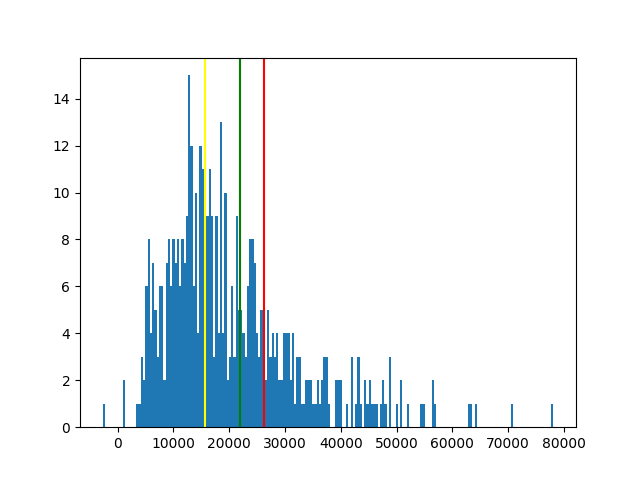

<IPython.core.display.Javascript object>


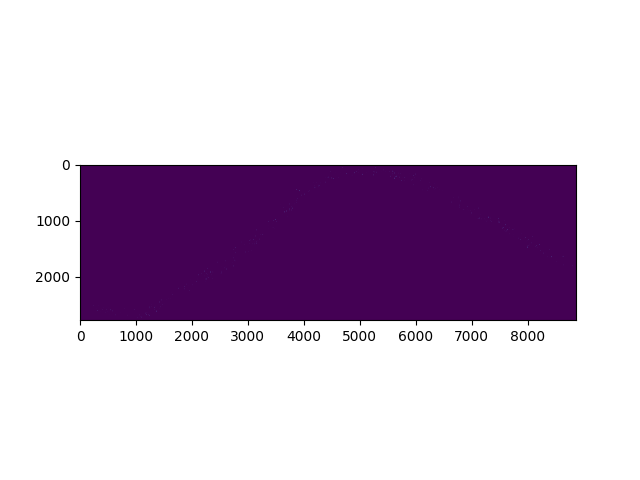

<IPython.core.display.Javascript object>

486
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_3_hipp_right_skan_2019-10-08_135307/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


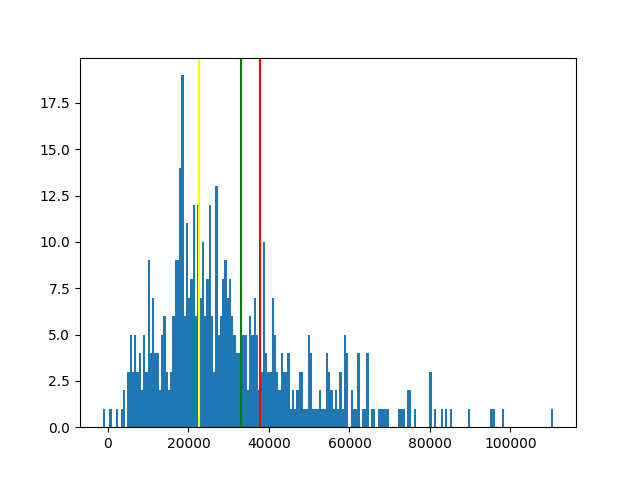

<IPython.core.display.Javascript object>


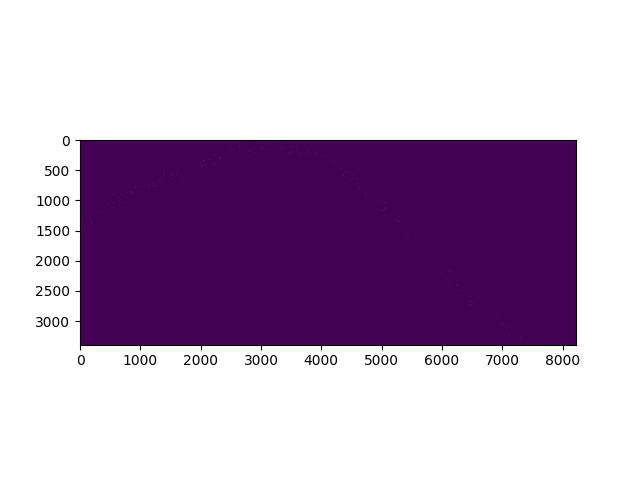

<IPython.core.display.Javascript object>


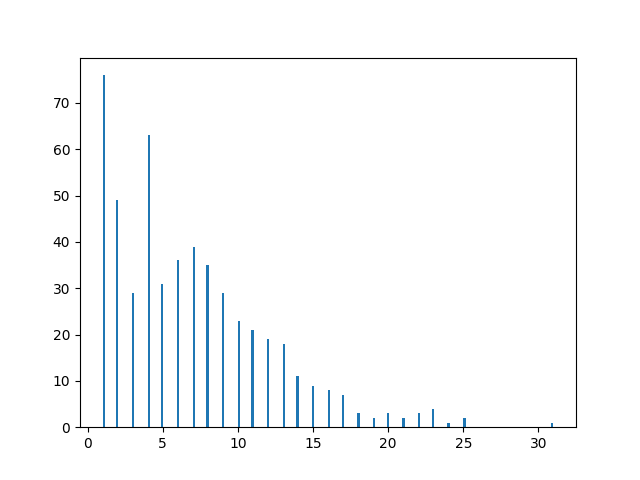

524
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_14_hipp_right_skan_2019-10-11_151922/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


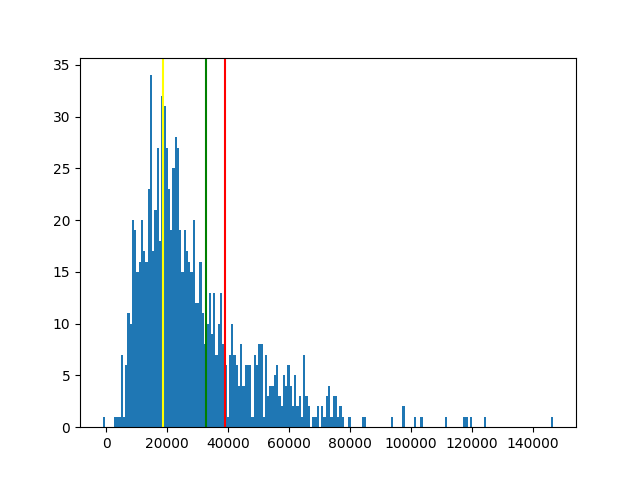

<IPython.core.display.Javascript object>


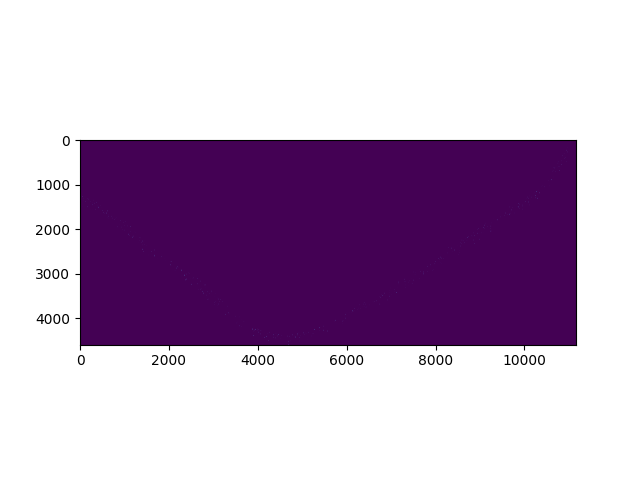

<IPython.core.display.Javascript object>

996
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


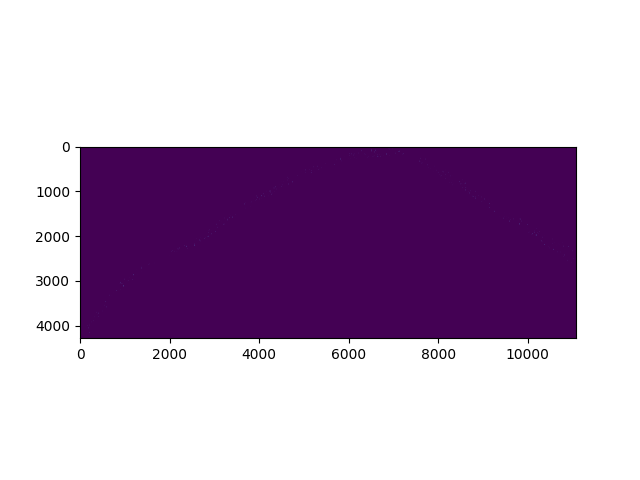

<IPython.core.display.Javascript object>


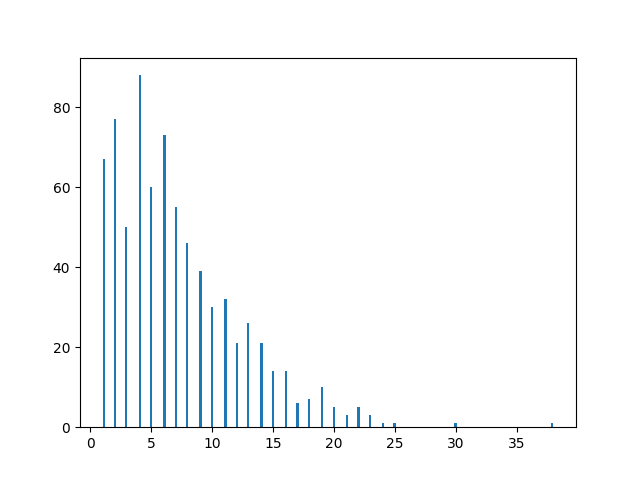

756
/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_13_hipp_left_skan_2019-10-11_114708/3.tif


<IPython.core.display.Javascript object>


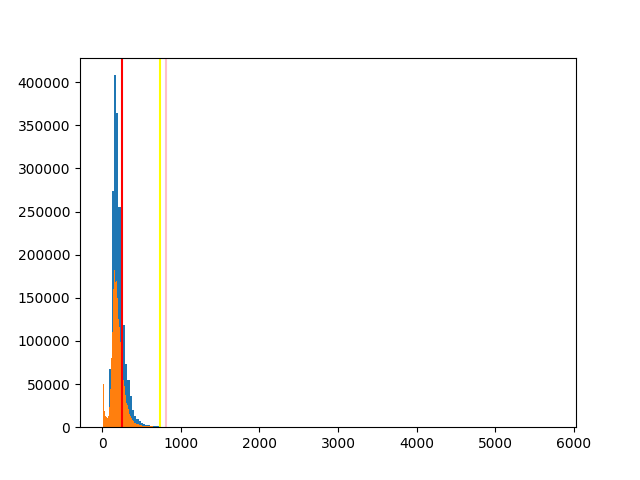

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


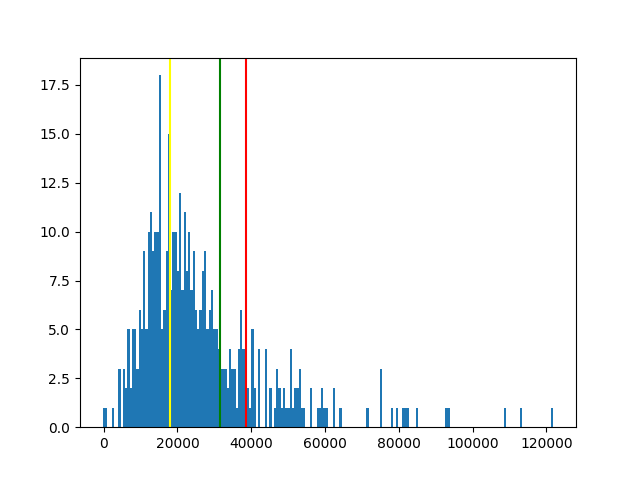

<IPython.core.display.Javascript object>


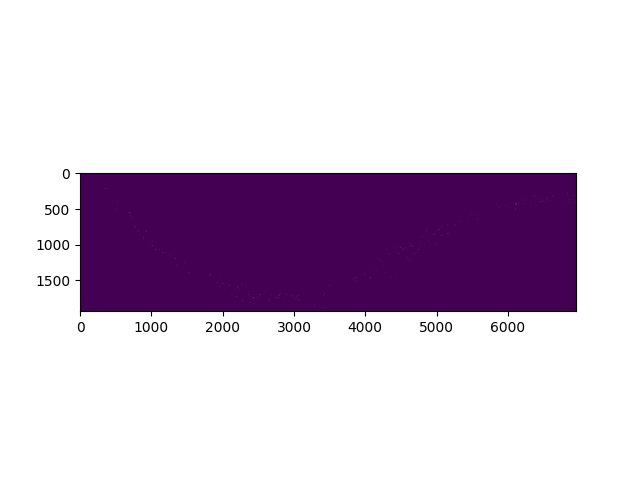

<IPython.core.display.Javascript object>


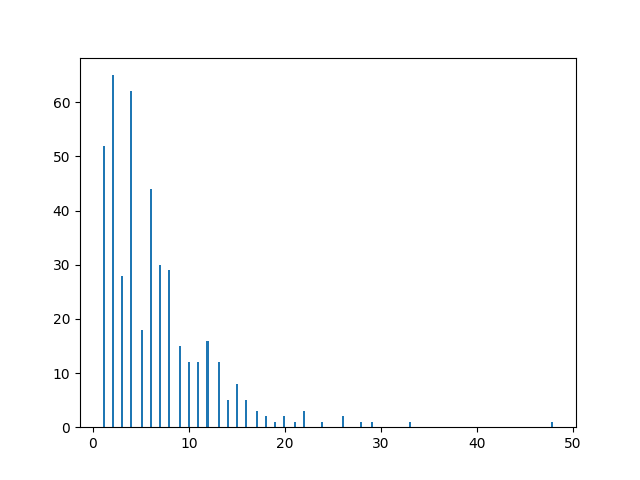

432
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_2_hipp_right_skan_2019-10-08_113103/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


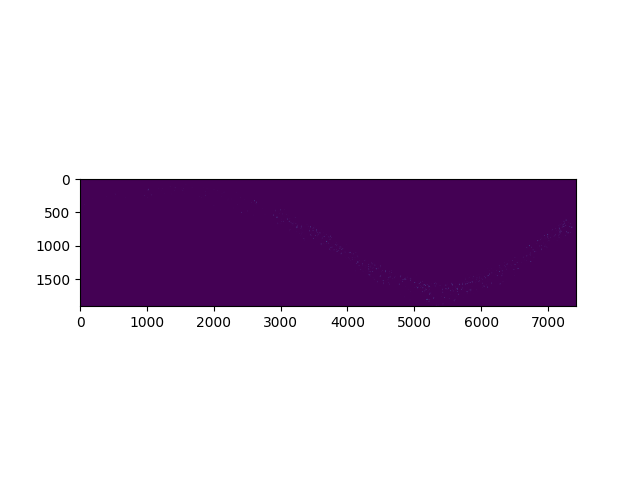

<IPython.core.display.Javascript object>

1079
/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_17_hipp_left_skan_2019-10-14_101906/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


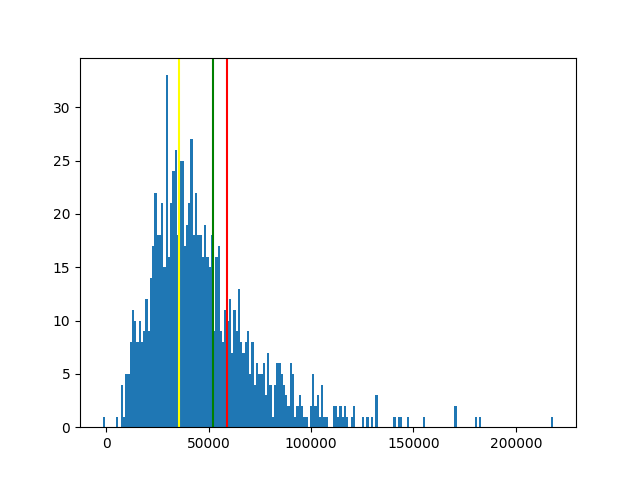

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


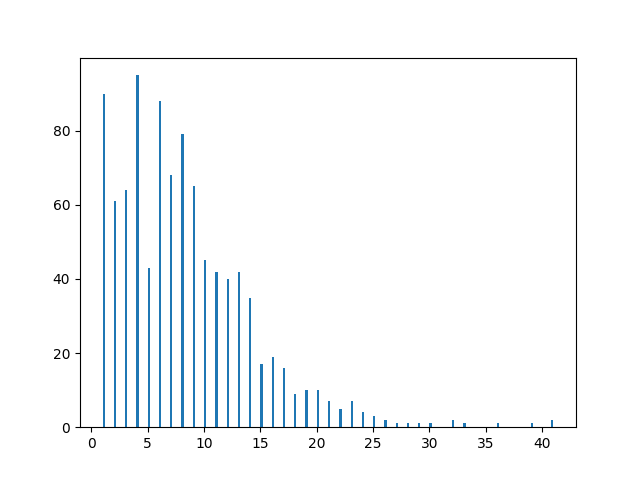

977
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_19_hipp_right_skan_2019-10-14_114530/3.tif


<IPython.core.display.Javascript object>


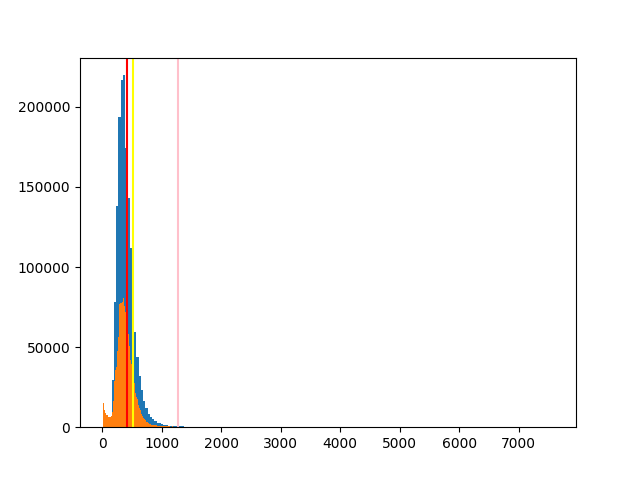

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


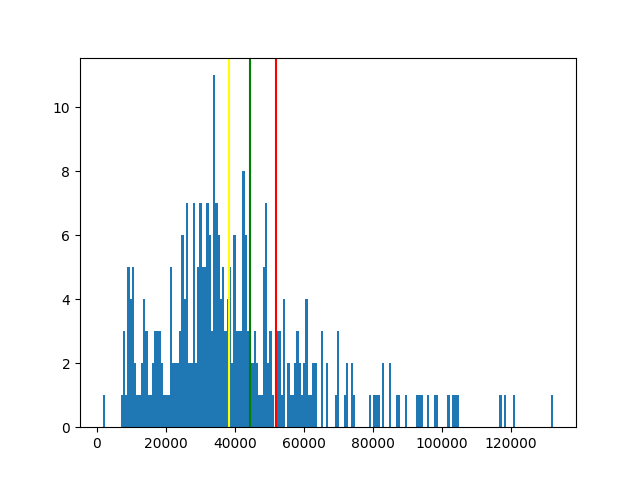

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

316
/mnt/ula/catfish/test_scans/CA1_left_glass_1_rat_3_hipp_left_skan_2019-10-08_130731/3.tif


<IPython.core.display.Javascript object>


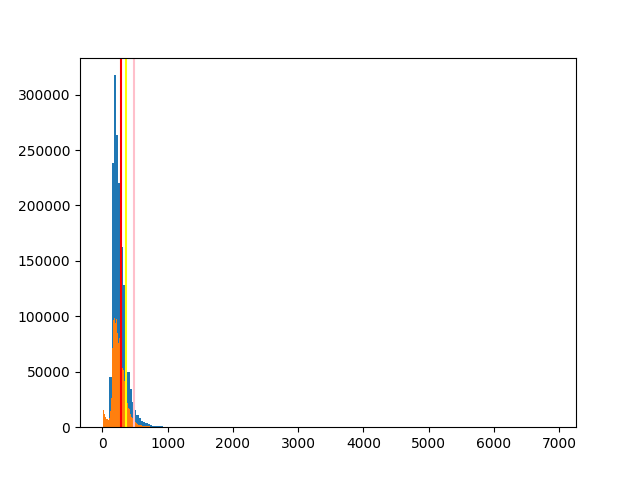

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


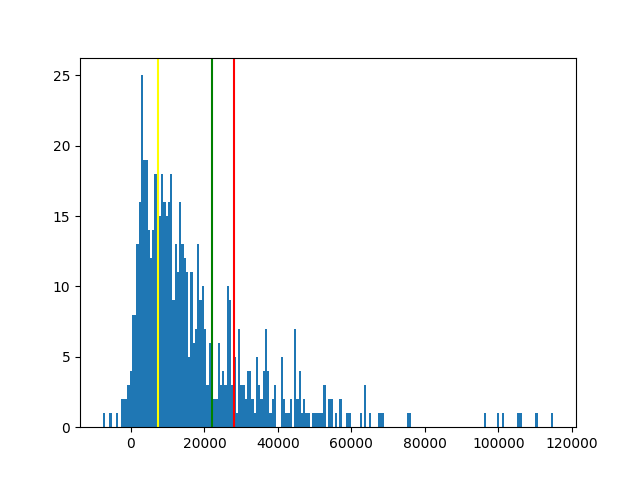

<IPython.core.display.Javascript object>


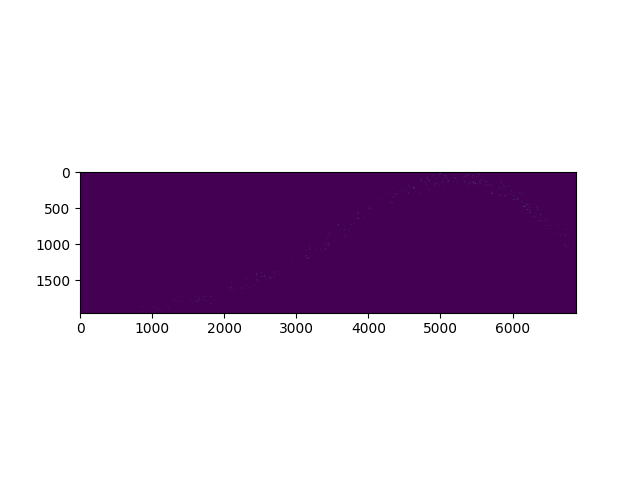

<IPython.core.display.Javascript object>


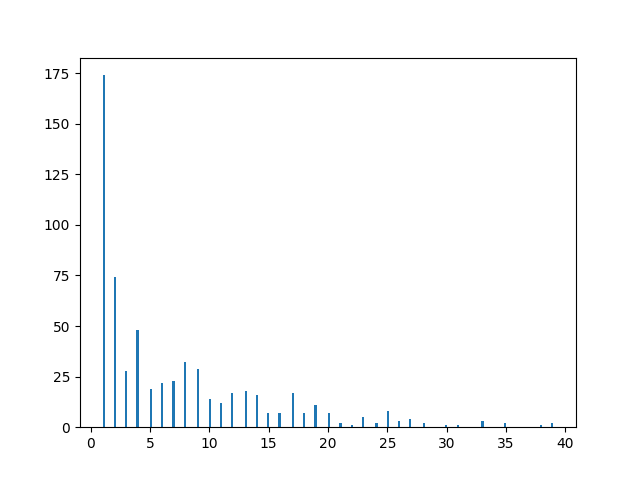

619
/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_11_hipp_right_skan_2019-10-11_102835/3.tif


<IPython.core.display.Javascript object>


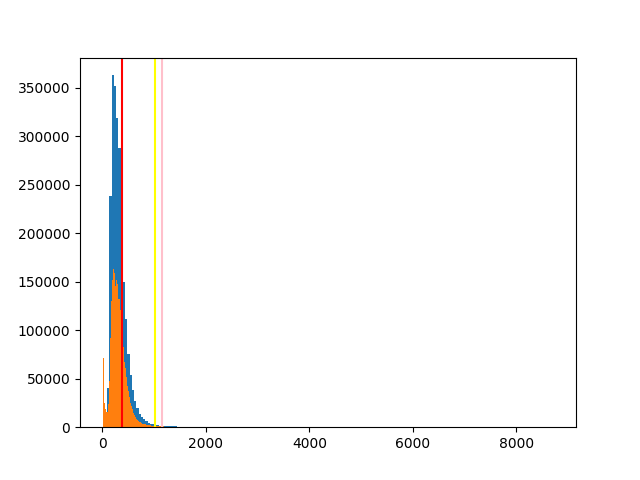

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


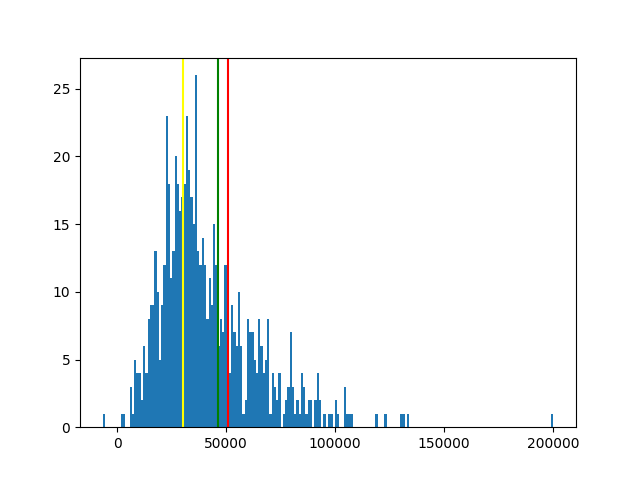

<IPython.core.display.Javascript object>


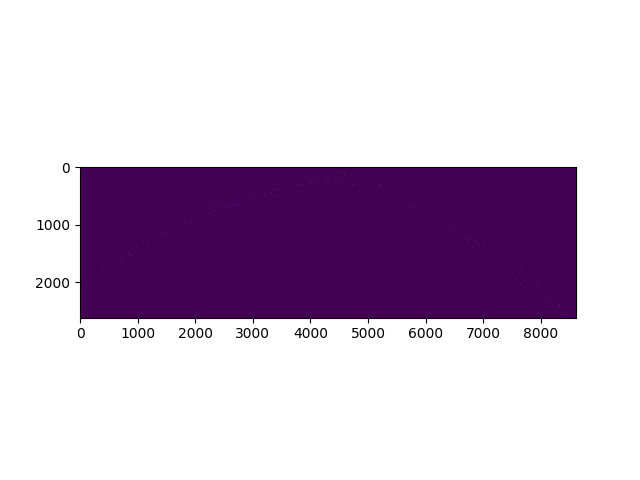

<IPython.core.display.Javascript object>


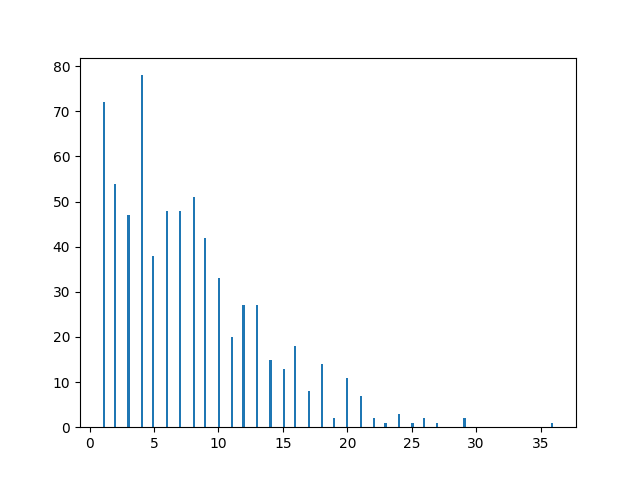

686
/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_6_hipp_right_skan_2019-10-09_114941/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


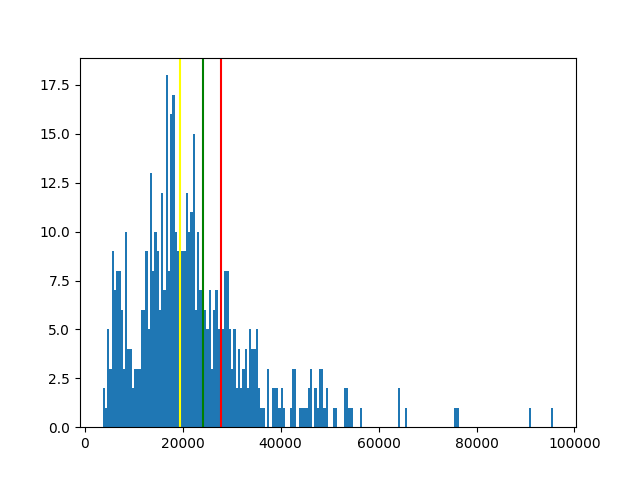

<IPython.core.display.Javascript object>


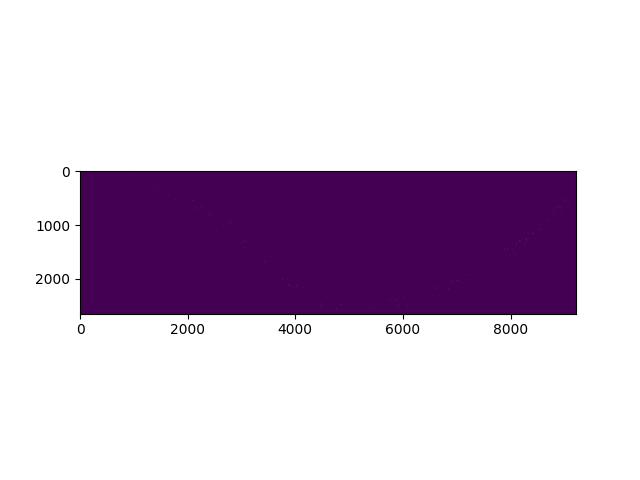

<IPython.core.display.Javascript object>


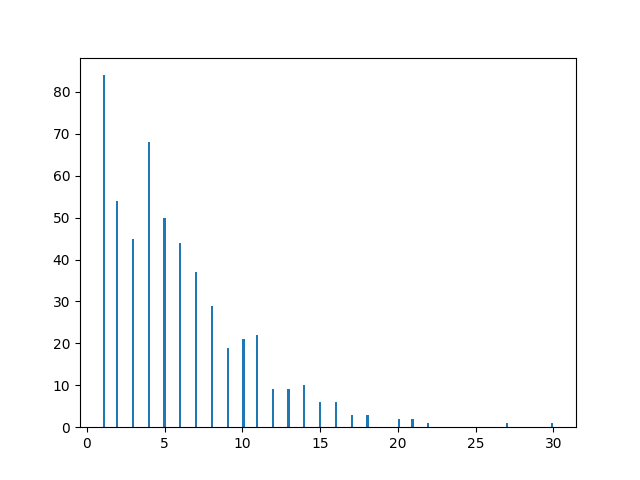

526
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_4_hipp_right_skan_2019-10-08_151512/3.tif


<IPython.core.display.Javascript object>


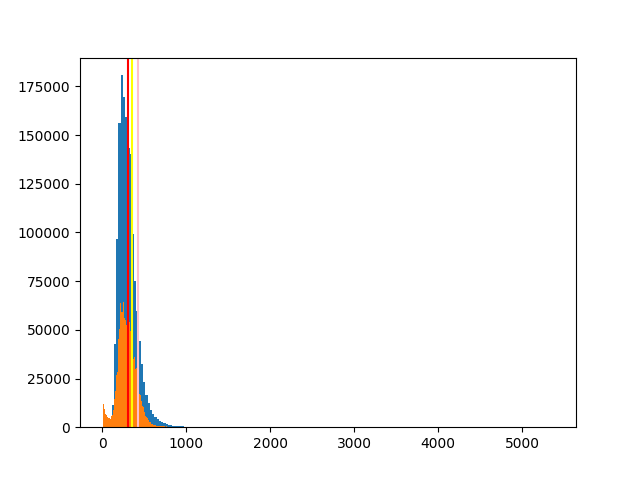

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


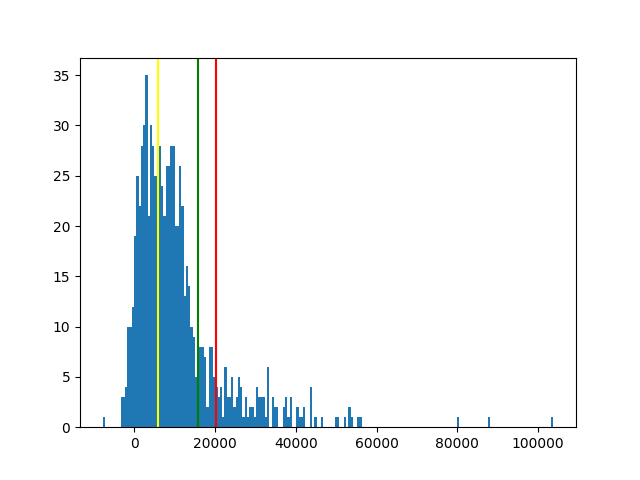

<IPython.core.display.Javascript object>


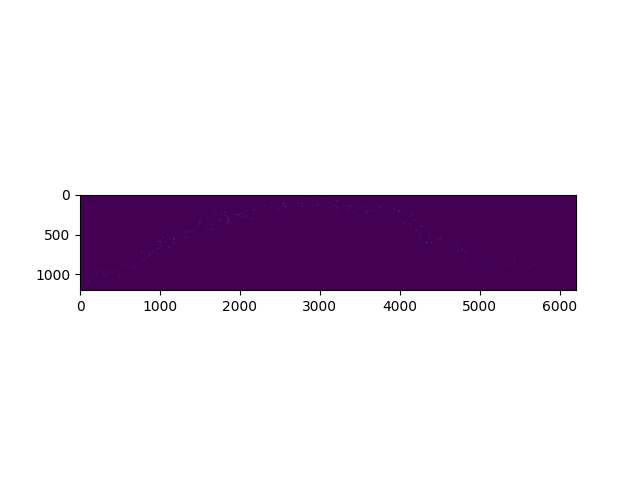

<IPython.core.display.Javascript object>


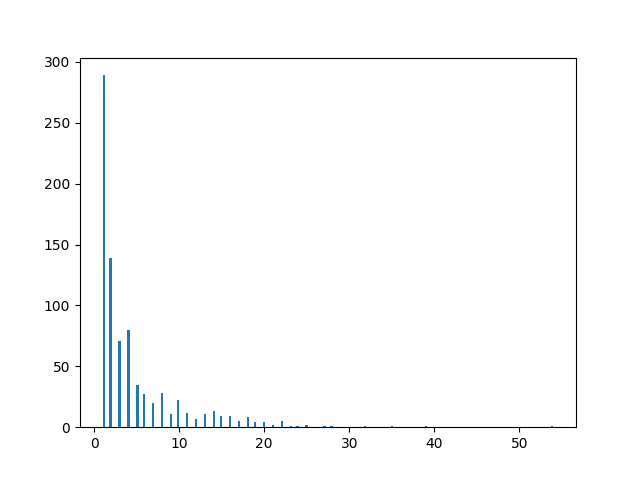

821
/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_18_hipp_left_skan_2019-10-14_144112/3.tif


<IPython.core.display.Javascript object>


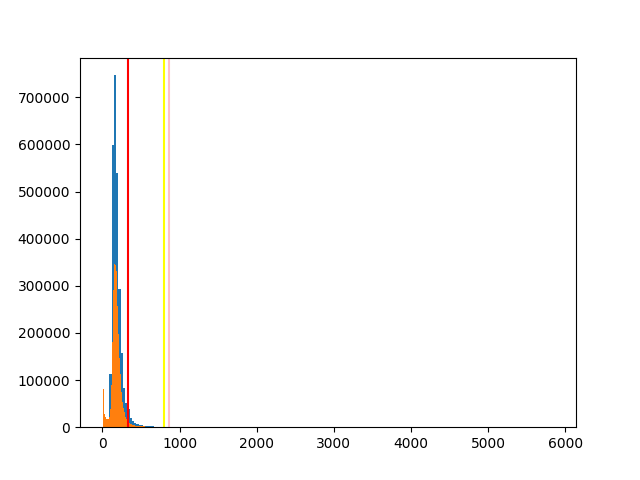

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


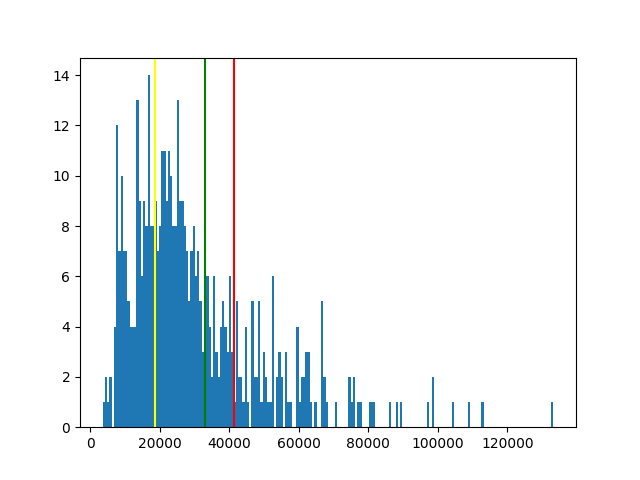

<IPython.core.display.Javascript object>


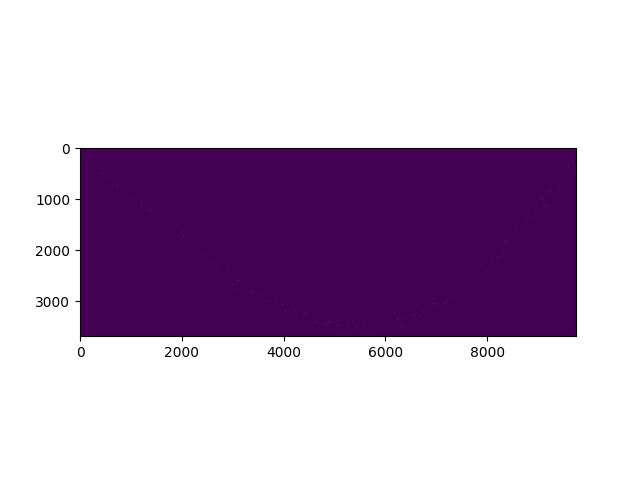

<IPython.core.display.Javascript object>


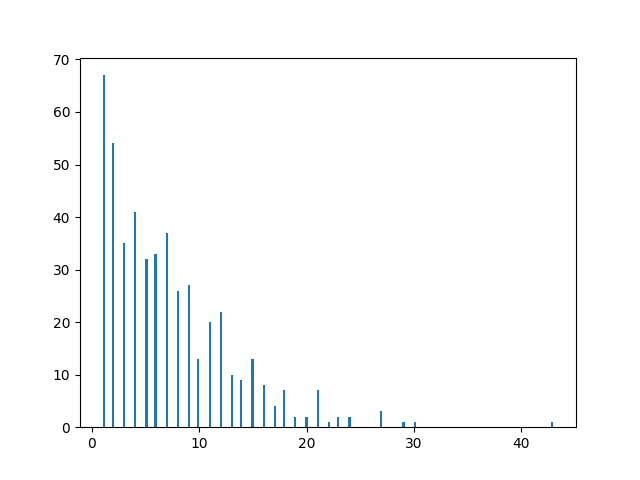

480
/mnt/ula/catfish/test_scans/CA1_left_glass_10_rat_7_hipp_left_skan_2019-10-08_155517/3.tif


<IPython.core.display.Javascript object>


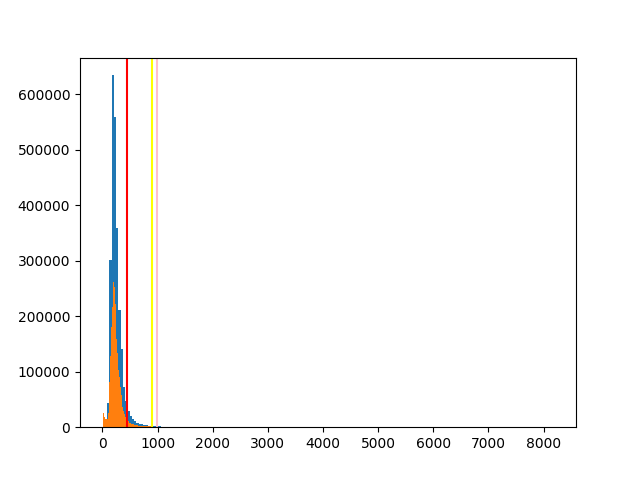

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

690
/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_19_hipp_left_skan_2019-10-14_110038/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


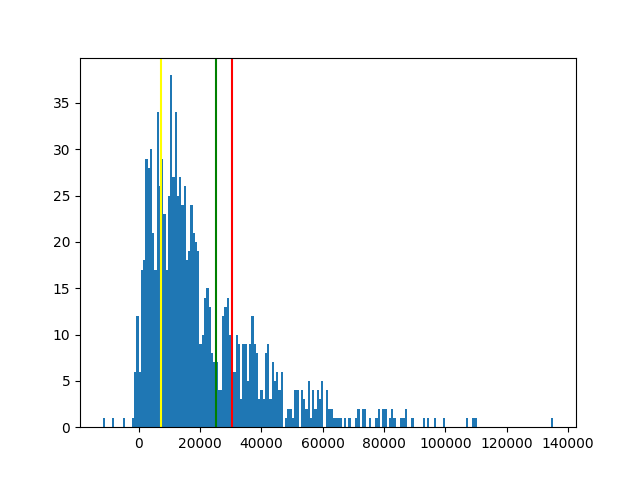

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


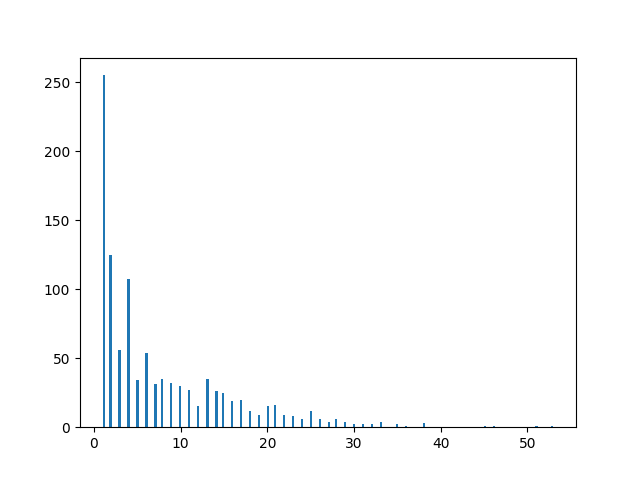

1053
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_16_hipp_right_skan_2019-10-11_143612/3.tif


<IPython.core.display.Javascript object>


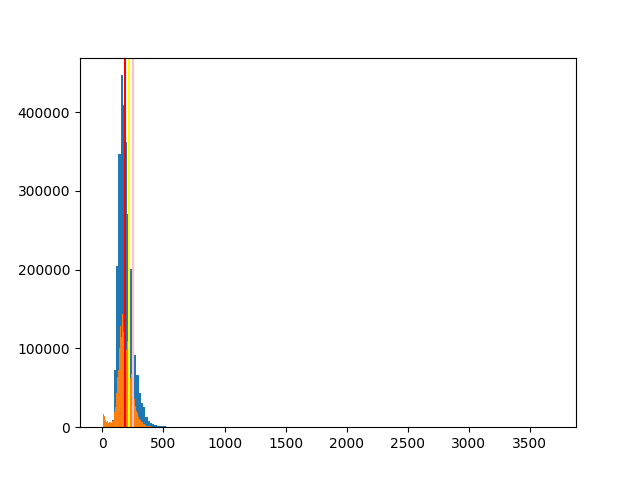

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


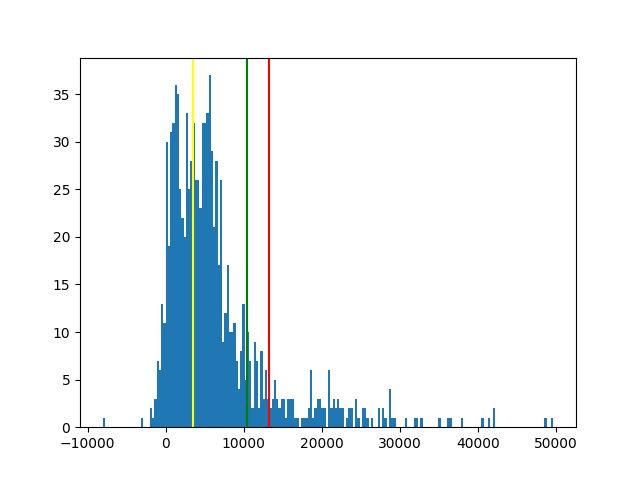

<IPython.core.display.Javascript object>


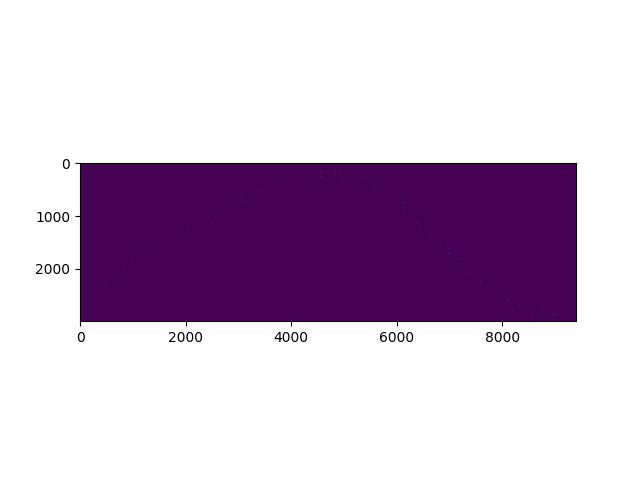

<IPython.core.display.Javascript object>


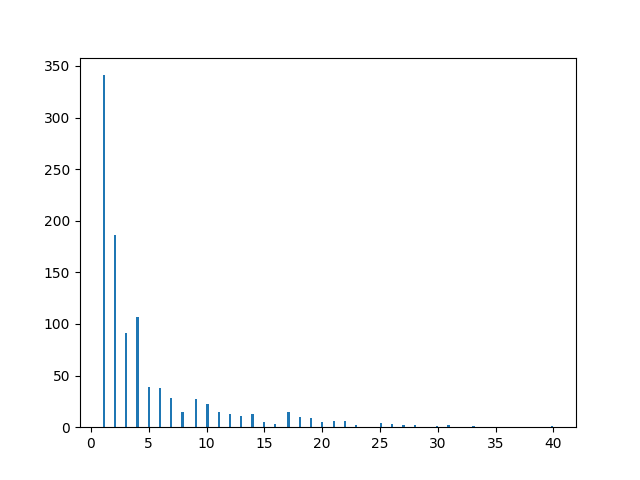

1023
/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_7_hipp_right_skan_2019-10-09_094010/3.tif


<IPython.core.display.Javascript object>


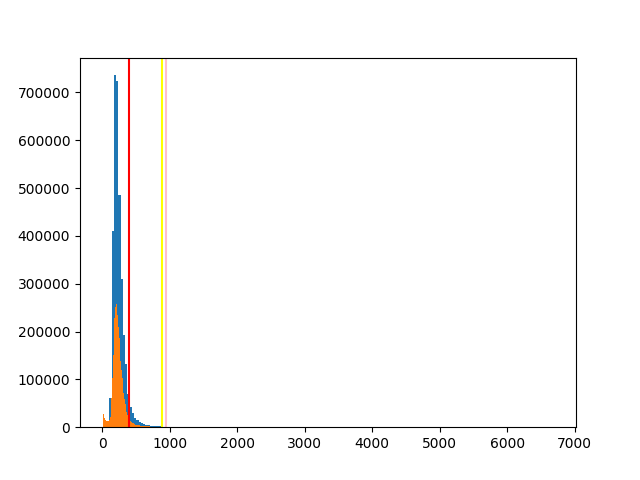

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


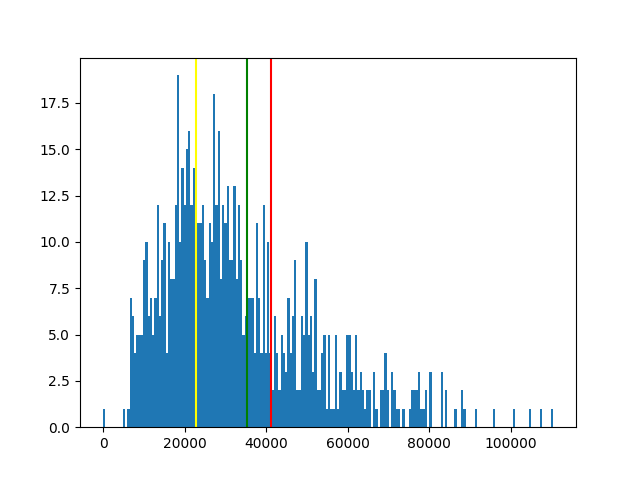

<IPython.core.display.Javascript object>


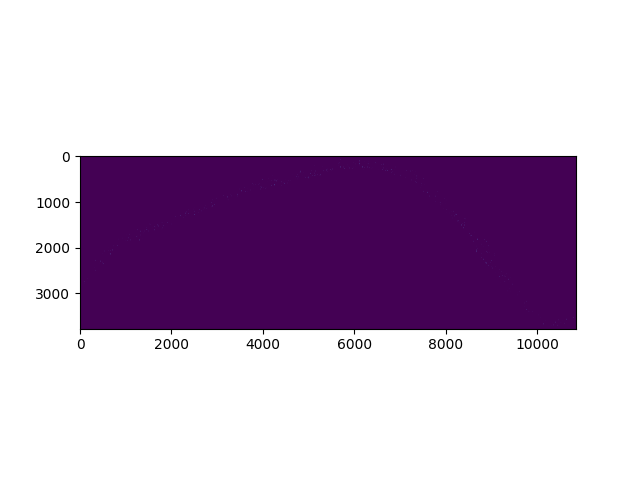

<IPython.core.display.Javascript object>


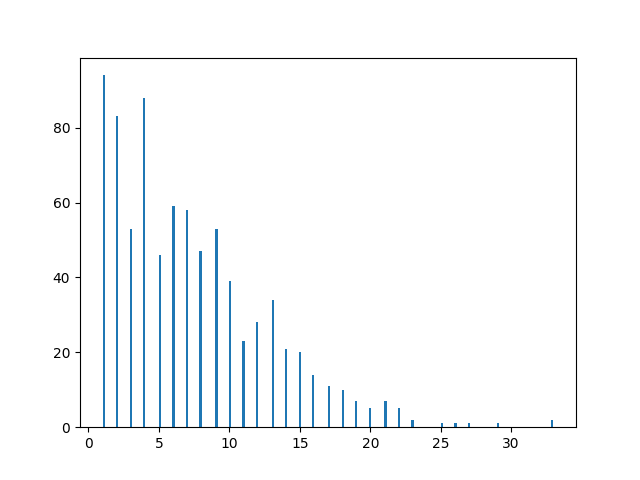

813
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_1_hipp_right_skan_2019-10-08_123824/3.tif


<IPython.core.display.Javascript object>


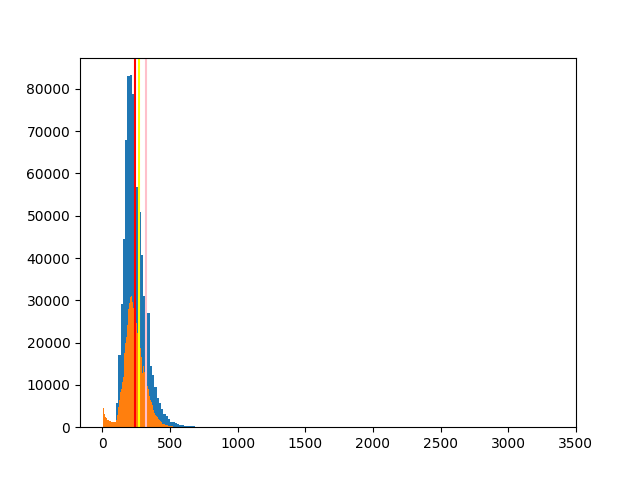

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


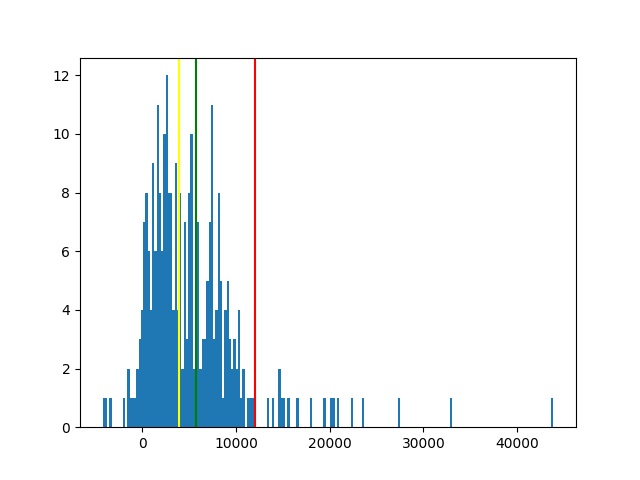

<IPython.core.display.Javascript object>


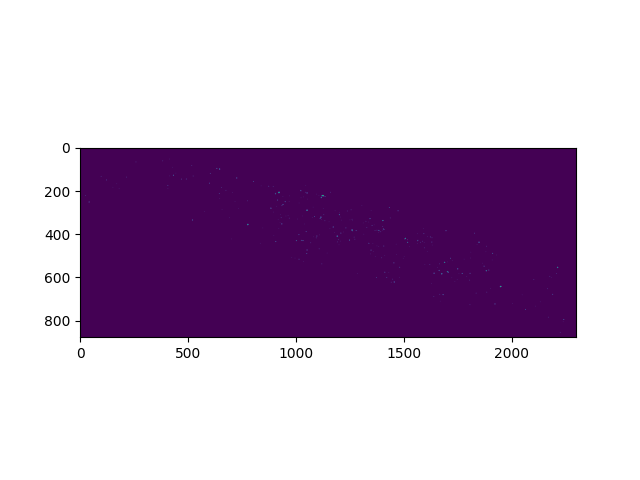

<IPython.core.display.Javascript object>


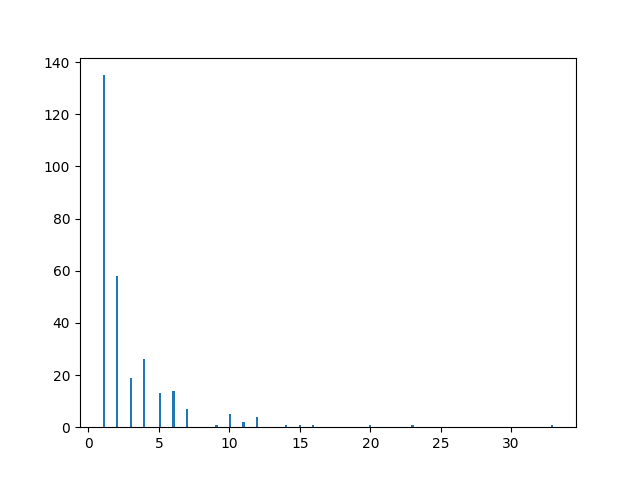

290
/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_9_hipp_right_skan_2019-10-09_145057/3.tif


<IPython.core.display.Javascript object>


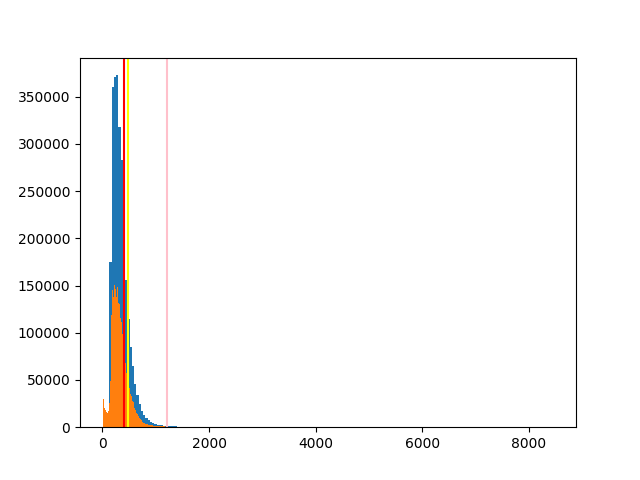

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


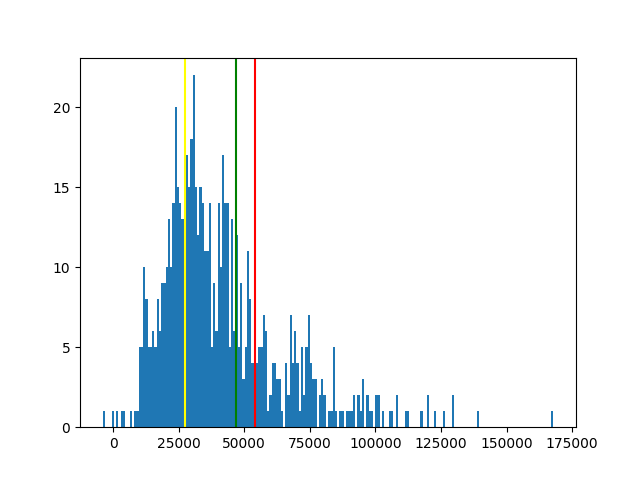

<IPython.core.display.Javascript object>


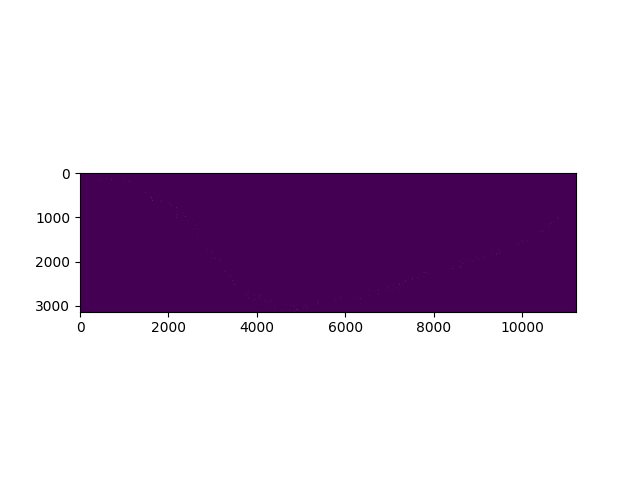

<IPython.core.display.Javascript object>


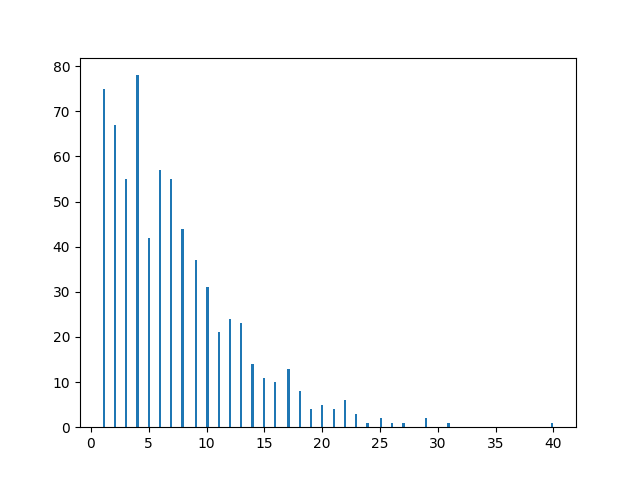

696
/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_5_hipp_right_skan_2019-10-09_102434/3.tif


<IPython.core.display.Javascript object>


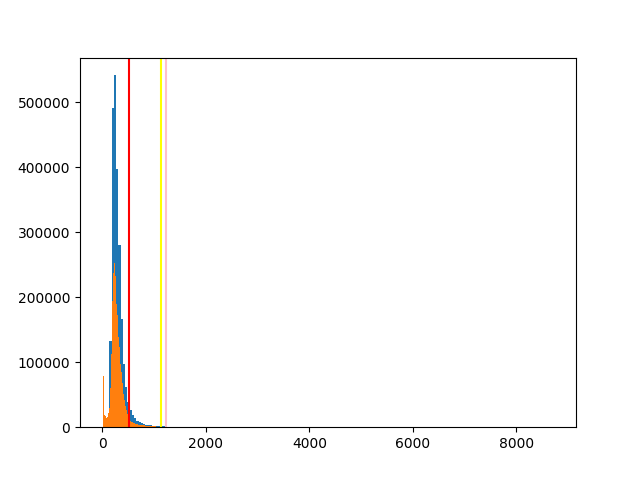

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


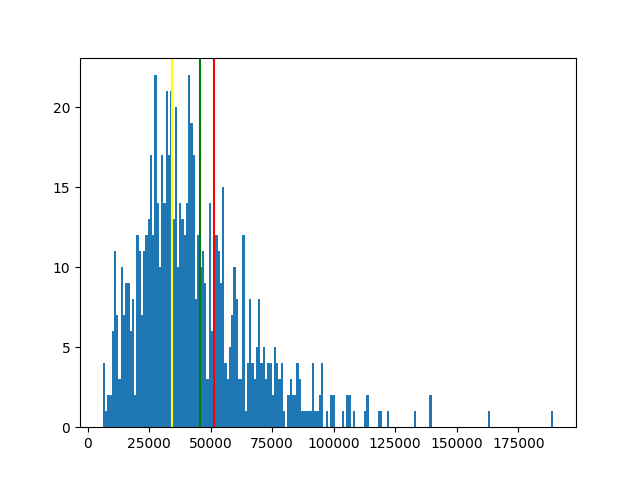

<IPython.core.display.Javascript object>


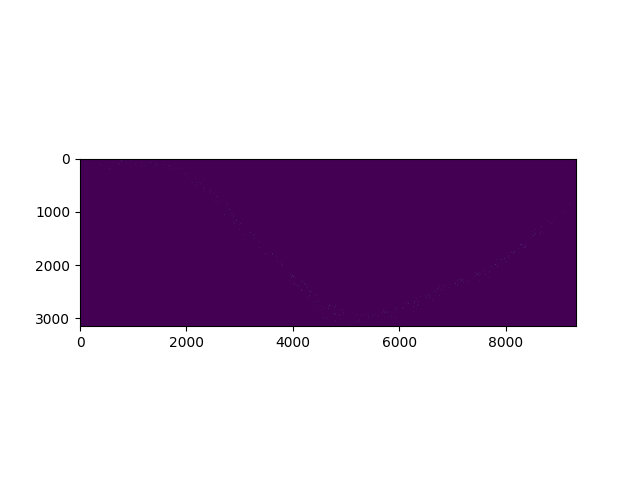

<IPython.core.display.Javascript object>


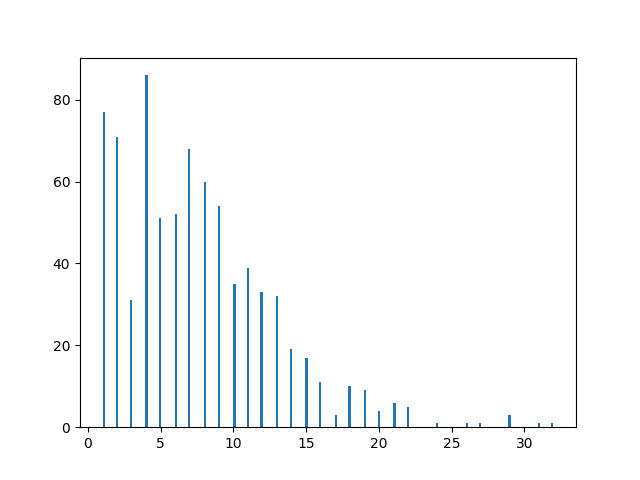

781
/mnt/ula/catfish/test_scans/CA1_left_glass_15_rat_11_hipp_left_skan_2019-10-11_094530/3.tif


<IPython.core.display.Javascript object>


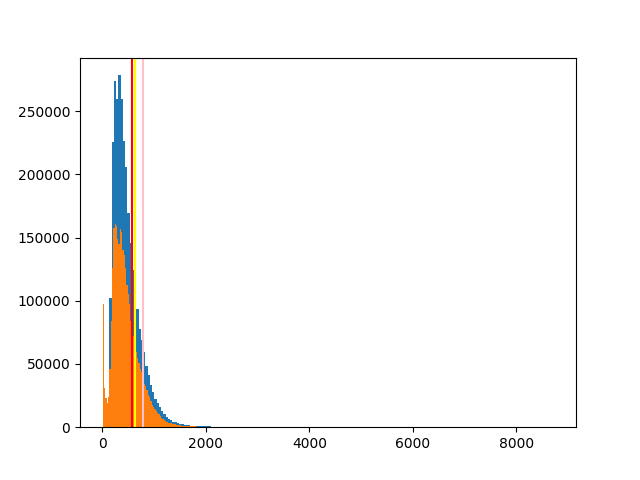

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


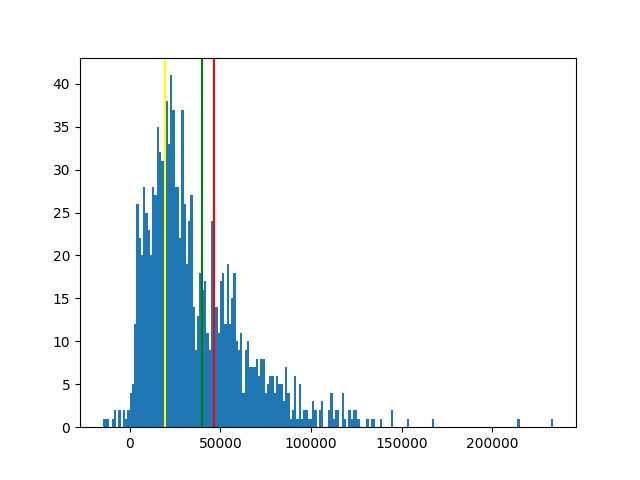

<IPython.core.display.Javascript object>


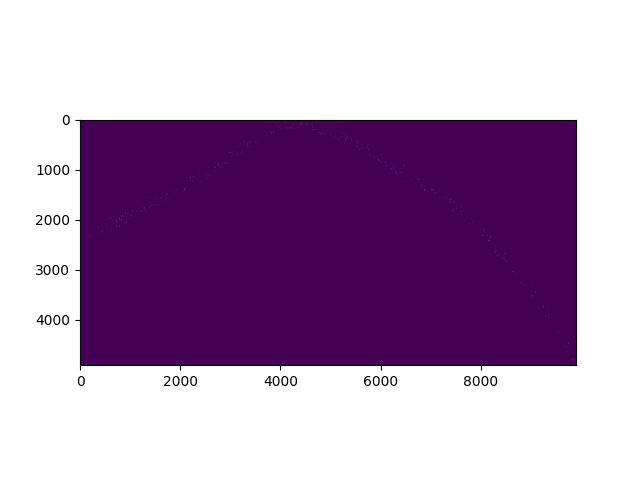

<IPython.core.display.Javascript object>


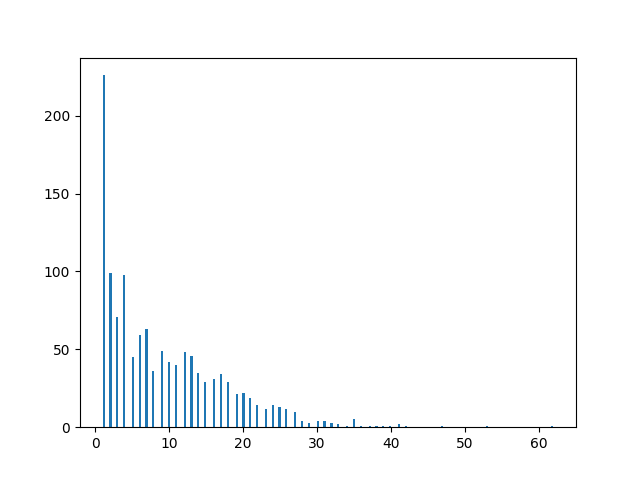

1254
/mnt/ula/catfish/test_scans/CA1_left_glass_15_rat_9_hipp_left_skan_2019-10-09_153930/3.tif


<IPython.core.display.Javascript object>


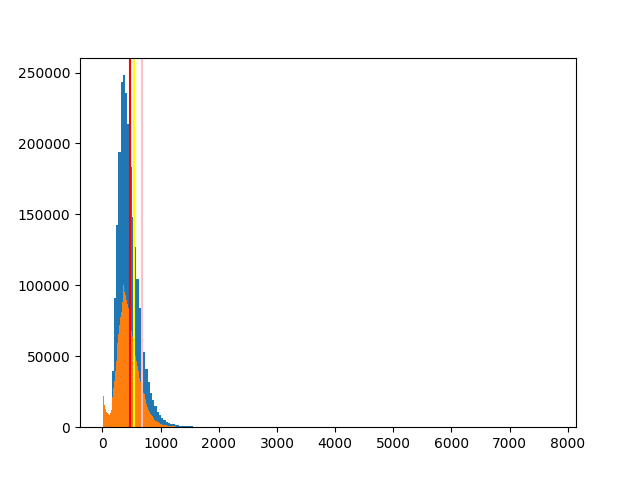

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


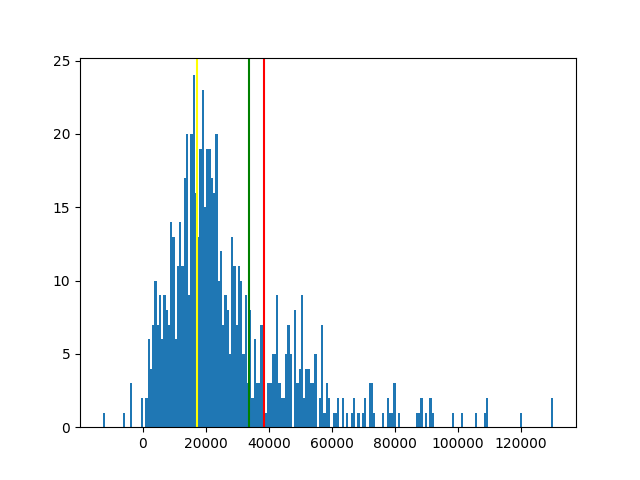

<IPython.core.display.Javascript object>


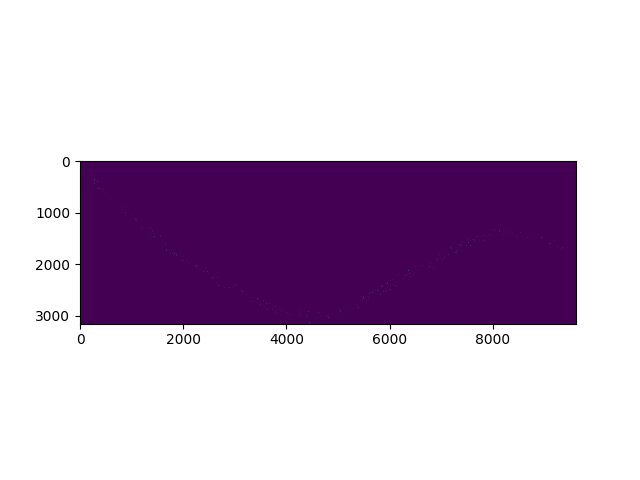

<IPython.core.display.Javascript object>


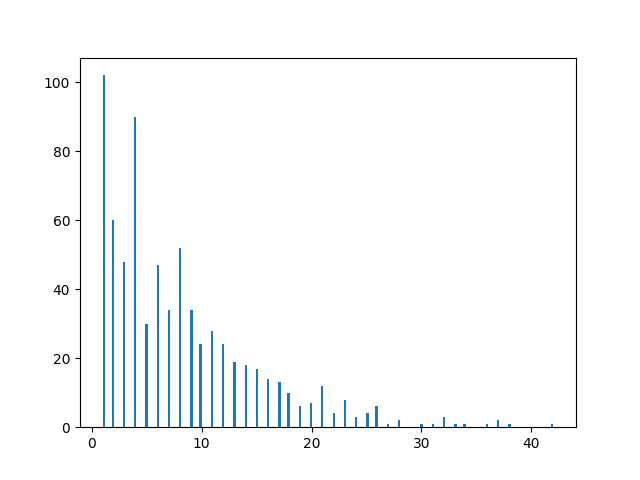

729
/mnt/ula/catfish/test_scans/CA1_left_glass_10_rat_8_hipp_left_skan_2019-10-09_140622/3.tif


<IPython.core.display.Javascript object>


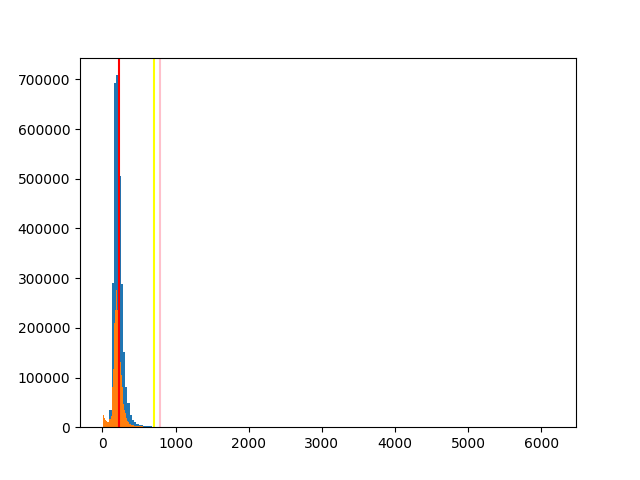

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


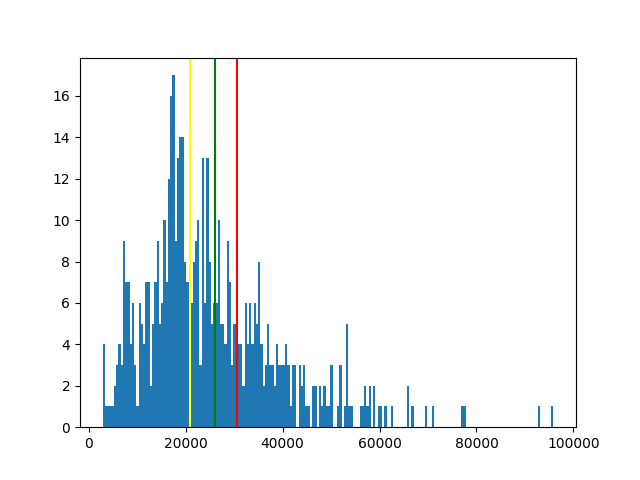

<IPython.core.display.Javascript object>


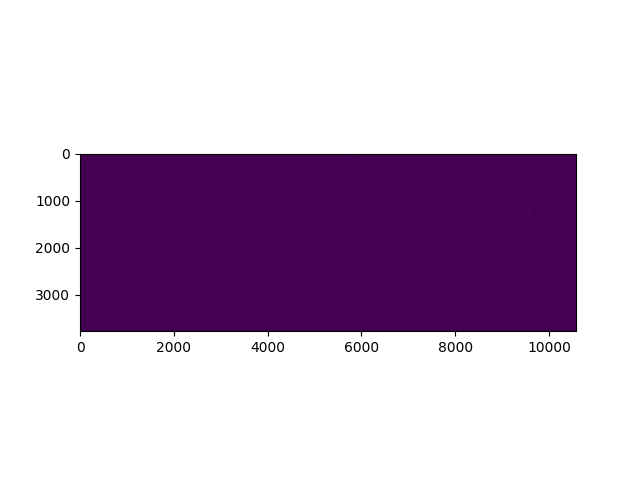

<IPython.core.display.Javascript object>


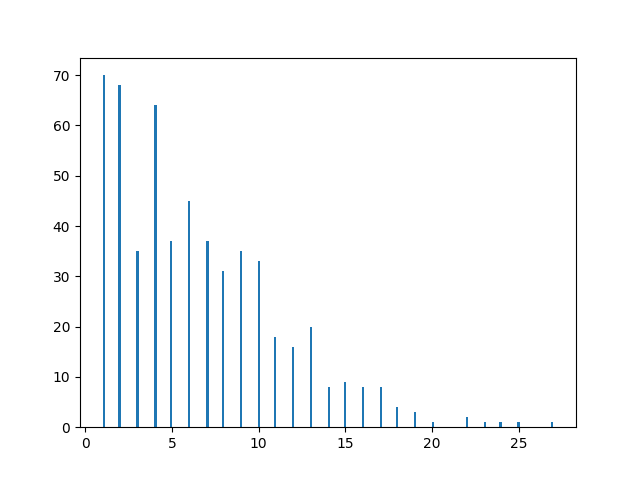

556
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_13_hipp_right_skan_2019-10-11_110942/3.tif


<IPython.core.display.Javascript object>


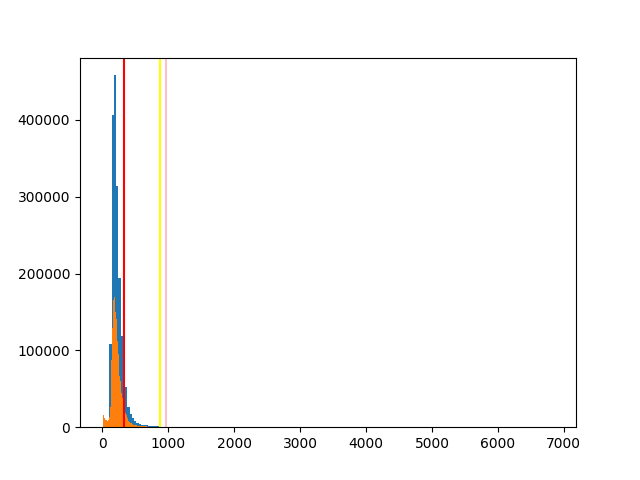

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


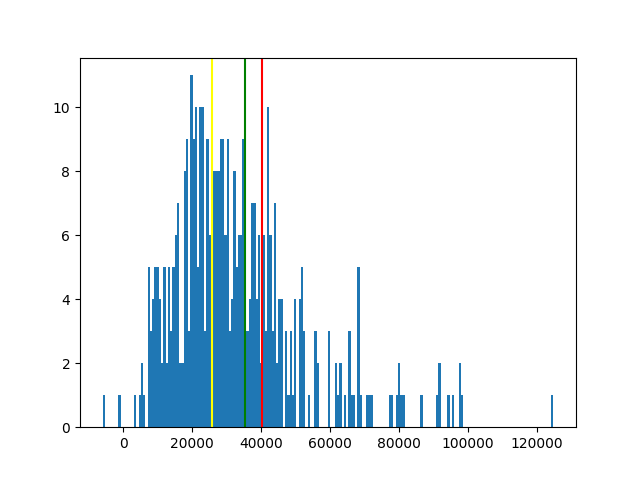

<IPython.core.display.Javascript object>


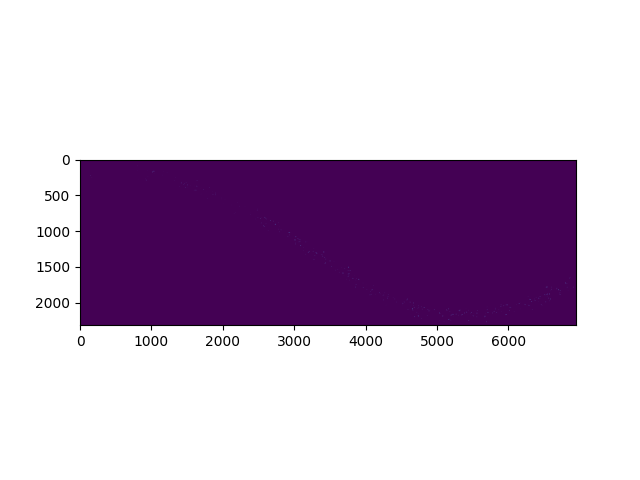

<IPython.core.display.Javascript object>


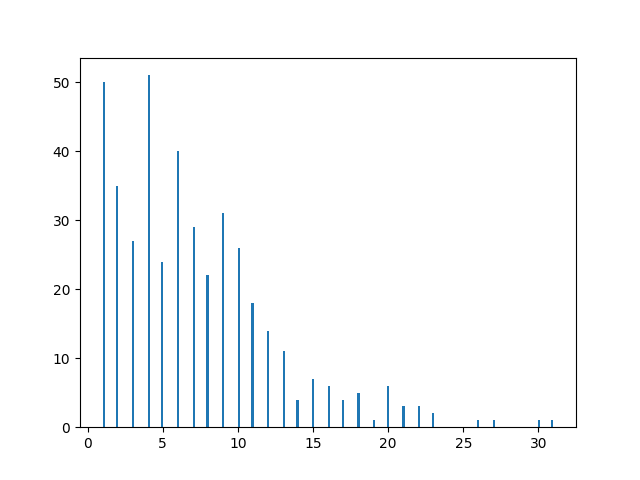

423
/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_14_hipp_left_skan_2019-10-11_161444/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


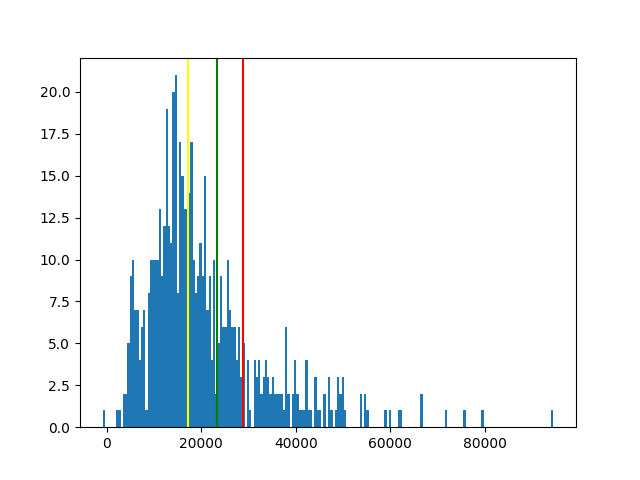

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

595
/mnt/ula/catfish/test_scans/CA1_left_glass_1_rat_2_hipp_left_skan_2019-10-08_105903/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


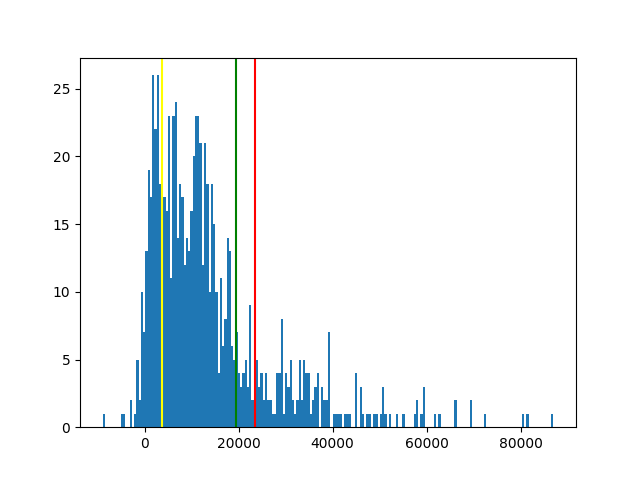

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

853
/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_20_hipp_left_skan_2019-10-14_122549/3.tif


<IPython.core.display.Javascript object>


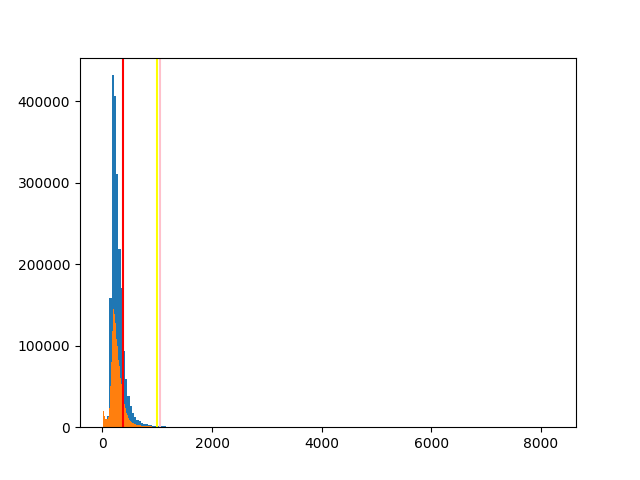

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


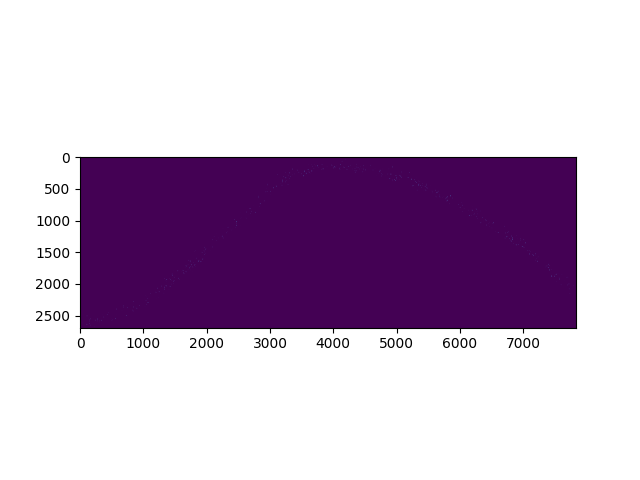

<IPython.core.display.Javascript object>


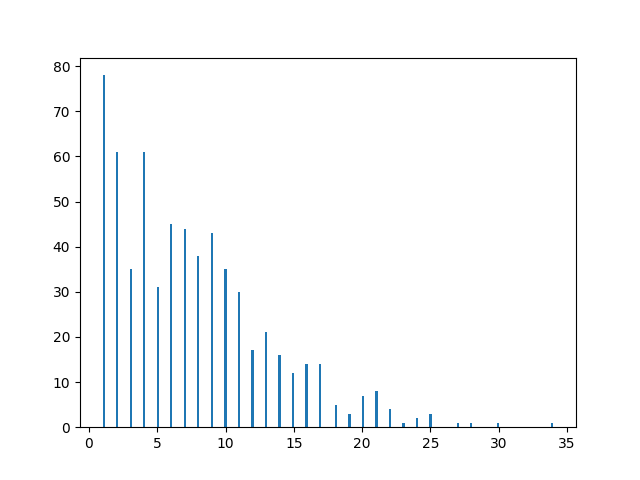

632
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_15_hipp_right_skan_2019-10-11_131148/3.tif


<IPython.core.display.Javascript object>


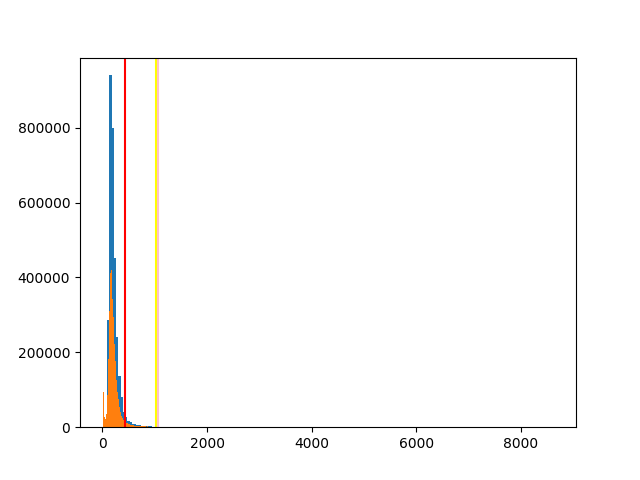

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


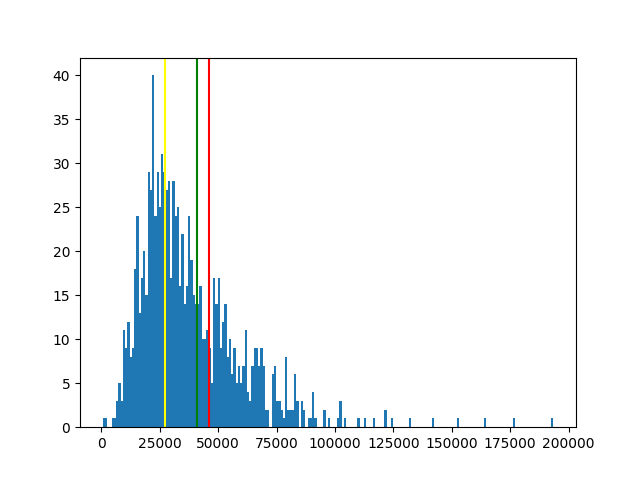

<IPython.core.display.Javascript object>


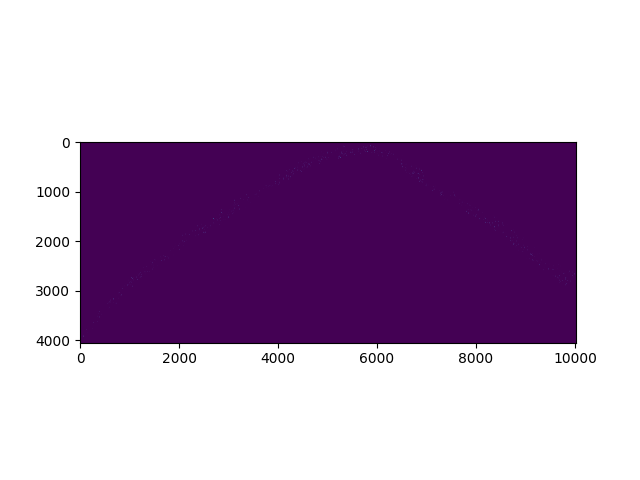

<IPython.core.display.Javascript object>


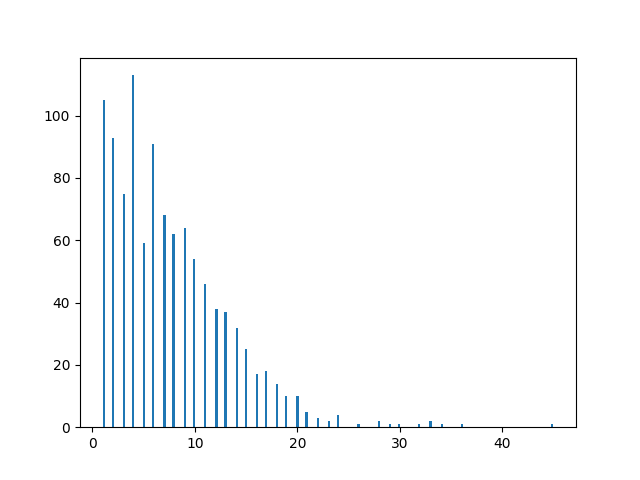

1056
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_18_hipp_right_skan_2019-10-14_135402/3.tif


<IPython.core.display.Javascript object>


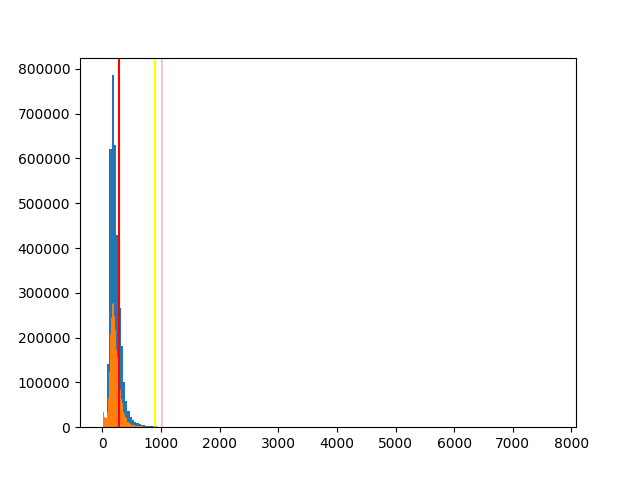

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


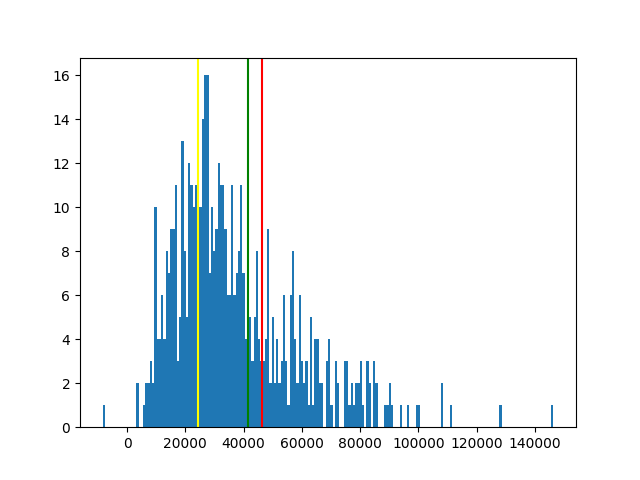

<IPython.core.display.Javascript object>


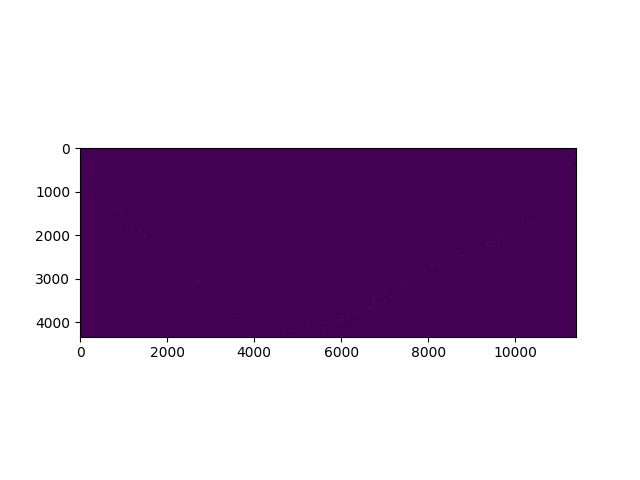

<IPython.core.display.Javascript object>

558
/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_12_hipp_right_skan_2019-10-10_155049/3.tif


<IPython.core.display.Javascript object>


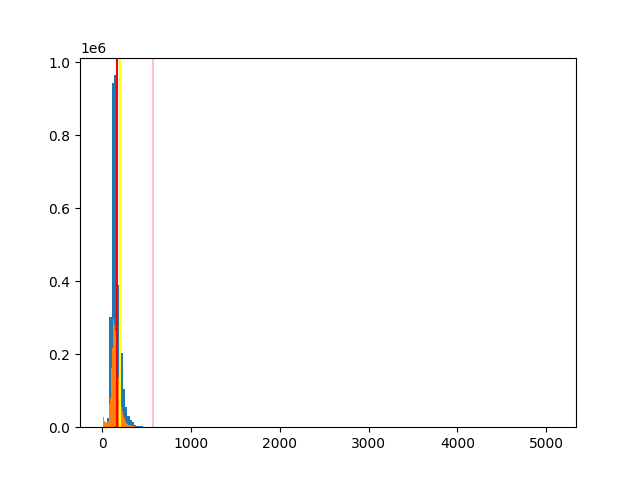

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


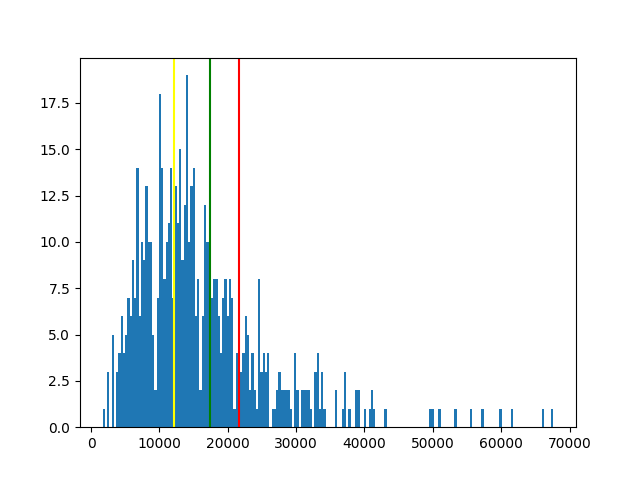

<IPython.core.display.Javascript object>


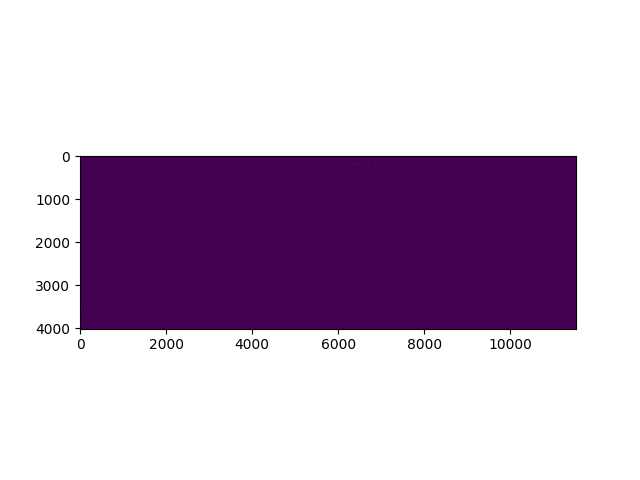

<IPython.core.display.Javascript object>


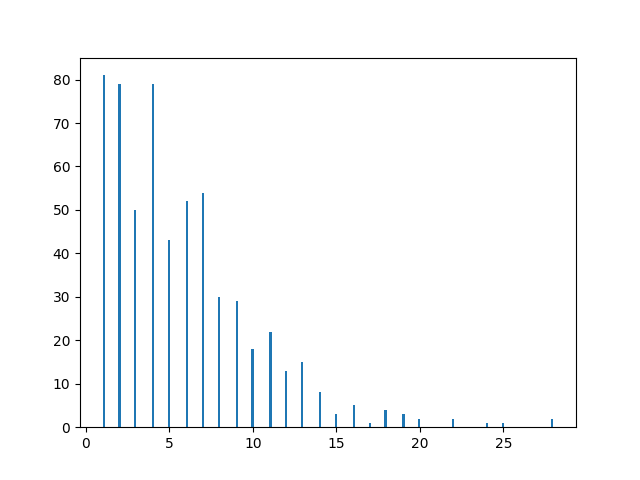

597
/mnt/ula/catfish/test_scans/CA1_left_glass_10_rat_5_hipp_left_skan_2019-10-09_111248/3.tif


<IPython.core.display.Javascript object>


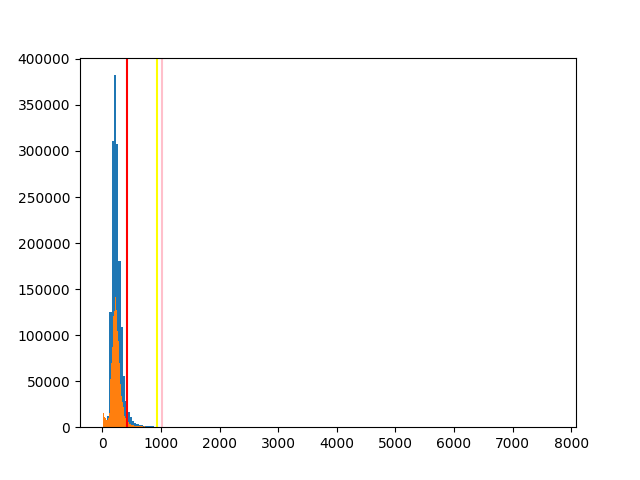

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


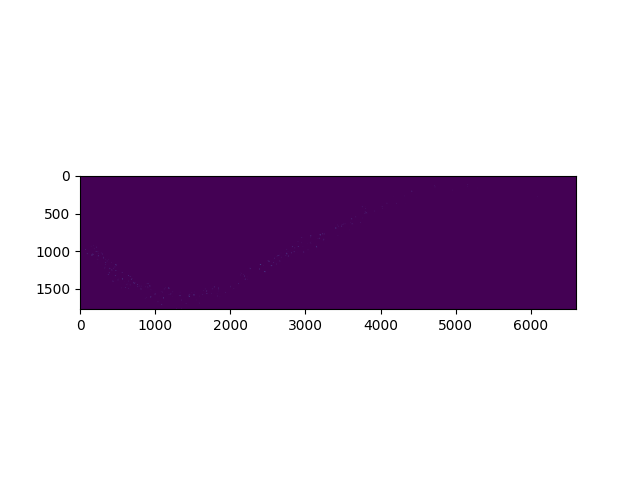

<IPython.core.display.Javascript object>


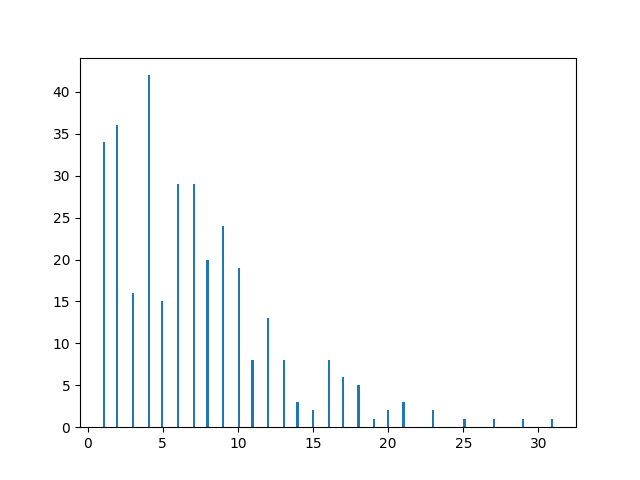

329


In [107]:
for result in results:
    show_hists(result, 1, 1)

In [108]:
for result in results:
    print(result.path)
    print(len(result.dots))

/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_16_hipp_left_skan_2019-10-11_135612
486
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_3_hipp_right_skan_2019-10-08_135307
524
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_14_hipp_right_skan_2019-10-11_151922
996
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039
756
/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_13_hipp_left_skan_2019-10-11_114708
432
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_2_hipp_right_skan_2019-10-08_113103
1079
/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_17_hipp_left_skan_2019-10-14_101906
977
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_19_hipp_right_skan_2019-10-14_114530
316
/mnt/ula/catfish/test_scans/CA1_left_glass_1_rat_3_hipp_left_skan_2019-10-08_130731
619
/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_11_hipp_right_skan_2019-10-11_102835
686
/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_6_hipp_right_skan_2019-10-09_114941
526
/m

In [78]:
for result in results:
    #to do poprawy - drugi raz liczę to samo
    intensities = np.array([])
    for dot in result.dots:
        intensities = np.append(intensities, dot.intensity)
    result.thre = custom_intensity_thre(intensities)
    with open(result.path + csv_suffix, 'w', newline='') as csvfile:
        fieldnames = ['centroid_x', 'centroid_y', 'intensity']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        count = 0
        for dot in result.dots:
            if dot.intensity > result.thre:
                count +=1
                dot_centroid = dot.approx_patch.center
                writer.writerow({'centroid_x': dot_centroid[0],'centroid_y': dot_centroid[1], 'intensity': dot.intensity})
        print(count)

617
2188
1665
1156
839
2271
1447
1328
1091
920
1102
652
548
899
2147
542
1964
233
1788
1068
1385
2842
1110
861
1076
1682
1589
1209
719
739
642


/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_3_hipp_right_skan_2019-10-08_135307/3.tif


<IPython.core.display.Javascript object>

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


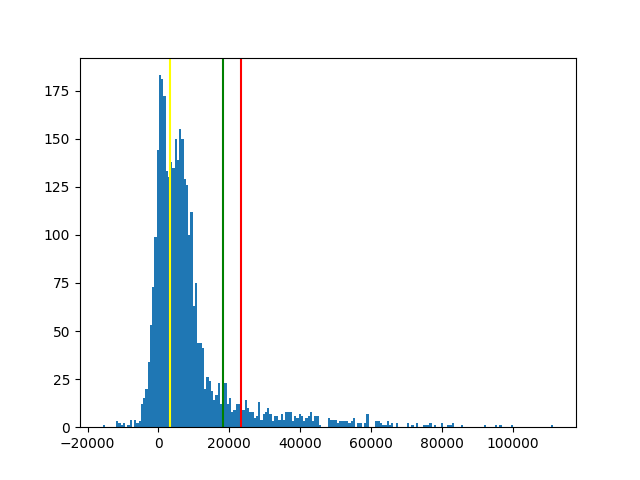

<IPython.core.display.Javascript object>


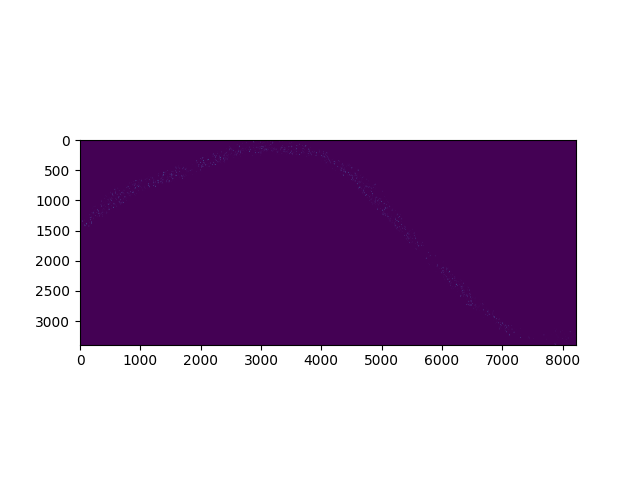

<IPython.core.display.Javascript object>


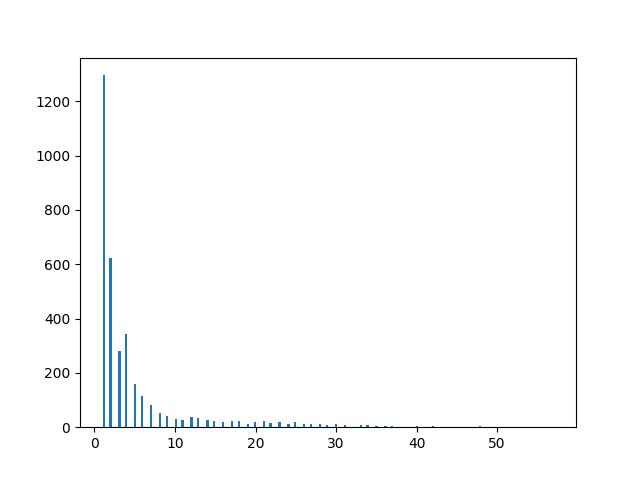

3460


In [105]:
show_hists(results[1], 1.5, 1)

/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_13_hipp_left_skan_2019-10-11_114708/3.tif


<IPython.core.display.Javascript object>


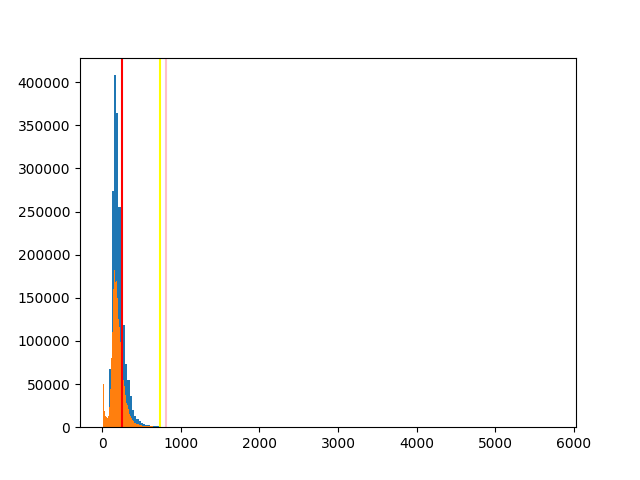

<ipython-input-40-b6aaae9487a3>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


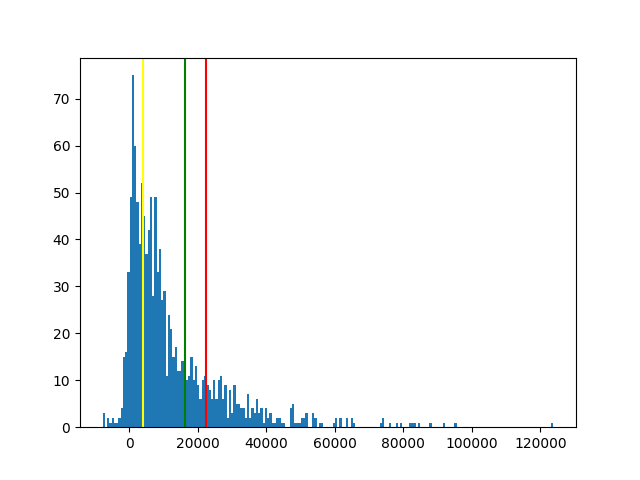

<IPython.core.display.Javascript object>


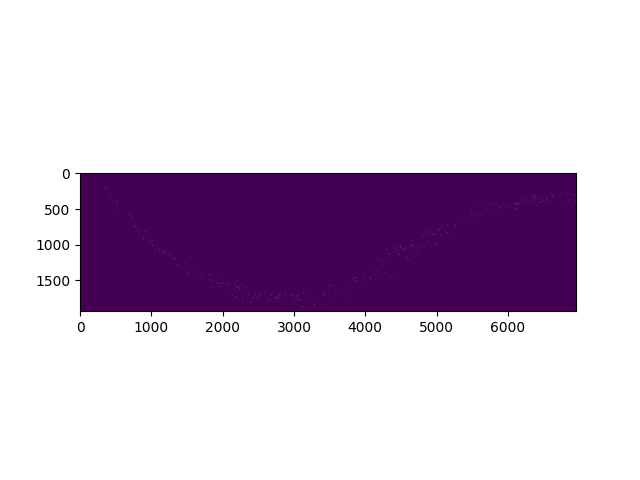

<IPython.core.display.Javascript object>

1229


In [103]:
show_hists(results[4], 1.5, 1)